In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tqdm import tqdm
import re
import scipy
import tensorflow
from tensorflow.keras.layers import Input,Flatten, Embedding, Reshape, Multiply, Dropout, Dense, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.layers import Layer, SpatialDropout1D, GlobalMaxPooling1D, Bidirectional, GRU, LSTM
from tensorflow.keras.layers import Dot, TimeDistributed, BatchNormalization, Add, Multiply
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
#import keras.backend as K
from sklearn.utils import shuffle
import seaborn as sns
import math
import shap

In [3]:
PATH = "../data/mind_small/"
news = pd.read_csv(PATH + "news.tsv",header=None, sep="\t")
behaviors = pd.read_csv(PATH + "behaviors.tsv", header=None, sep="\t")
news.columns = ["news_id", "category", "sub_category", "title", "abstract", "url", "title_entities", "abstract_entities"]
behaviors.columns = ["idx", "user_id", "time", "history", "impressions"]
behaviors = behaviors.drop_duplicates(["user_id", "history"]) 
behaviors.dropna(subset=["user_id", "history"], inplace=True)

In [4]:
sessions = {}
for idx, row in behaviors.iterrows():
    sessions[row["user_id"]] = row["history"].split(" ")

users = []
clicks = []
for k, v in sessions.items():
    for elem in v:
        users.append(k)
        clicks.append(elem)

tuples = list(zip(users, clicks))
interactions = pd.DataFrame(tuples, columns=["user", "news_id"])
interactions = interactions[:10000]

In [5]:
merged = interactions.merge(news, on=["news_id"])
merged.head()

,user,news_id,category,sub_category,title,abstract,url,title_entities,abstract_entities
0,U13740,N55189,tv,tvnews,"'Wheel Of Fortune' Guest Delivers Hilarious, O...","We'd like to solve the puzzle, Pat: Blair Davi...",https://assets.msn.com/labs/mind/AAIORni.html,[],"[{""Label"": ""Pat Sajak"", ""Type"": ""P"", ""Wikidata..."
1,U10045,N55189,tv,tvnews,"'Wheel Of Fortune' Guest Delivers Hilarious, O...","We'd like to solve the puzzle, Pat: Blair Davi...",https://assets.msn.com/labs/mind/AAIORni.html,[],"[{""Label"": ""Pat Sajak"", ""Type"": ""P"", ""Wikidata..."
2,U85394,N55189,tv,tvnews,"'Wheel Of Fortune' Guest Delivers Hilarious, O...","We'd like to solve the puzzle, Pat: Blair Davi...",https://assets.msn.com/labs/mind/AAIORni.html,[],"[{""Label"": ""Pat Sajak"", ""Type"": ""P"", ""Wikidata..."
3,U78244,N55189,tv,tvnews,"'Wheel Of Fortune' Guest Delivers Hilarious, O...","We'd like to solve the puzzle, Pat: Blair Davi...",https://assets.msn.com/labs/mind/AAIORni.html,[],"[{""Label"": ""Pat Sajak"", ""Type"": ""P"", ""Wikidata..."
4,U27024,N55189,tv,tvnews,"'Wheel Of Fortune' Guest Delivers Hilarious, O...","We'd like to solve the puzzle, Pat: Blair Davi...",https://assets.msn.com/labs/mind/AAIORni.html,[],"[{""Label"": ""Pat Sajak"", ""Type"": ""P"", ""Wikidata..."


# 1. Preprocessing

In [6]:
# remove users which have fewer than 5 interacations
print("Len before removal: ",len(merged))
_keys = merged["user"].value_counts()[merged["user"].value_counts() > 5].keys()
merged = merged[merged["user"].isin(_keys)]
print("Len after removal: ",len(merged))


user_enc = LabelEncoder()
article_enc = LabelEncoder()
merged["user_id"] = user_enc.fit_transform(merged["user"].values)
merged["article_id"] = article_enc.fit_transform(merged["news_id"].values)




Len before removal:  10000
Len after removal:  9867


In [7]:
import nltk
from nltk.corpus import stopwords
# Helper functions
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

def text_to_list(text):
    text = text.split(" ")
    return text

In [8]:
def clean_title(df):
    df["title_cleaned"] = df.title.apply(func = make_lower_case)
    df["title_cleaned"] = df.title_cleaned.apply(func = remove_stop_words)
    df["title_cleaned"] = df.title_cleaned.apply(func = remove_punctuation)
    return df
def hyphen_to_underline(category):
    """
    Convert hyphen to underline for the subcategories. So that Tfidf works correctly
    """
    return category.replace("-","_")
merged = clean_title(merged)
merged["subcategory_cleaned"] = merged["sub_category"].apply(func = hyphen_to_underline)

In [9]:
vectorizer = TfidfVectorizer(analyzer="word", tokenizer=str.split)
item_ids = merged["article_id"].unique().tolist()
tfidf_matrix = vectorizer.fit_transform(merged["subcategory_cleaned"])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<9867x164 sparse matrix of type '<class 'numpy.float64'>'
	with 9867 stored elements in Compressed Sparse Row format>

In [10]:
item_ids = merged["article_id"].tolist()

def get_item_profile(item_id):
    """
    item_id: the news article id
    Return: an array of each n-gram in the item article. 
        with their n-gram id in tfidf_feature_names and weight.
    """
    idx = item_ids.index(item_id) # returns the index to the item id
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile
    
def get_item_profiles(ids):
    #print(ids)
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_user_profile(person_id):
    interactions = merged[merged["user_id"] == person_id]["article_id"].values # gets all articles
    user_item_profiles = get_item_profiles(interactions)
    user_item_profiles = np.sum(user_item_profiles, axis=0)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_profiles)
    return user_item_profiles
    
#t = build_user_profile(1)

In [11]:
def calculate_user_profiles(unique_user_ids):
    user_profiles = {}
    for idx in tqdm(unique_user_ids):
        token_relevance = build_user_profile(idx).tolist()[0]
        zipped = zip(tfidf_feature_names, token_relevance)
        s = sorted(zipped, key=lambda x: -x[-1])[:6]
        user_profiles[idx] = s
    return user_profiles
        
user_profiles = calculate_user_profiles(merged["user_id"].unique())


100%|██████████| 231/231 [00:07<00:00, 28.88it/s]


In [12]:
subcategory_to_id = {name: idx+1 for idx, name in enumerate(tfidf_feature_names)}
id_to_subcategory = {idx: name for name, idx in subcategory_to_id.items()}
id_to_subcategory[0] = "Null"
subcategory_to_id["Null"] = 0

In [13]:
# add all id-category to the userprofile in df
profile_array = []
for index, row in tqdm(merged.iterrows()):
    
    user_idx = row["user_id"]
    profile = user_profiles[user_idx]
    temp = []
    for keyword_tuple in profile:
        temp.append(subcategory_to_id[keyword_tuple[0]])
    profile_array.append(temp)
merged["profile"] = profile_array

9867it [00:00, 12796.85it/s]


In [14]:
# add the id-category to the news articles
merged["subcategory_to_int"] = [subcategory_to_id[cat] for cat in merged["subcategory_cleaned"].values]

user_unique = merged.drop_duplicates("user_id")
userid_to_profile = user_unique[["user_id", "profile"]].set_index("user_id").to_dict()["profile"]

category_enc = LabelEncoder()
merged["main_category_int"] = category_enc.fit_transform(merged["category"].values)
article_id_to_category_int = merged[["article_id", "main_category_int"]].set_index("article_id").to_dict()
article_id_to_category_int = article_id_to_category_int["main_category_int"]

article_id_to_subcategory_int = merged[["article_id", "subcategory_to_int"]].set_index("article_id").to_dict()
article_id_to_subcategory_int = article_id_to_subcategory_int["subcategory_to_int"]

# 2. Train-test-split

In [15]:
def train_test_split(df, user_id, article_id, have_timestamp, timestamp):
    """
    params: 
        col_1: user_id
        col_2: article_id
    """
    df_test = df
    if have_timestamp: # if df have timestamp; take last interacted article into test set
        df_test = df_test.sort_values(timestamp).groupby(user_id).tail(1)
    else:
        df_test = df_test.sort_values(user_id).groupby(user_id).tail(1)
    df_train = df.drop(index=df_test.index)
    
    assert df_test.shape[0] + df_train.shape[0] == df.shape[0]
    
    return df_train, df_test
df_train_true, df_test_true = train_test_split(merged, "user_id", "article_id", False, 0)

In [16]:
def get_userid_to_article_history(df):
    userid_to_article_history = {}
    for user_id in tqdm(df["user_id"].unique()):
        click_history = df[df["user_id"] == user_id]["article_id"].values
        if len(click_history) < 30:
            while len(click_history) < 30:
                click_history = np.append(click_history, 0)
        if len(click_history) > 30:
            click_history = click_history[:30]
        userid_to_article_history[user_id] = click_history
    return userid_to_article_history
userid_to_article_history = get_userid_to_article_history(df_train_true)

100%|██████████| 231/231 [00:00<00:00, 1559.99it/s]


In [17]:
all_article_ids = merged["article_id"].unique()

def negative_sampling(train_df, all_article_ids, user_id, article_id):
    """
    Negative sample training instance; for each positive instance, add 4 negative articles
    
    Return user_ids, news_ids, category_1, category_2, authors_onehotencoded, titles
    """
    
    user_ids, user_click_history, articles, article_category, article_sub_category, labels = [], [], [], [], [], []
    p0, p1, p2, p3, p4, p5, p6, p7, p8, p9 = [], [], [], [], [], [], [], [], [], []
    user_item_set = set(zip(train_df[user_id], 
                            train_df[article_id]))
    num_negatives = 4

    for (u, i) in tqdm(user_item_set):
        user_ids.append(u)
        user_click_history.append(userid_to_article_history[u])
        profile = np.array(userid_to_profile[u])
        p0.append(profile[0])
        p1.append(profile[1])
        p2.append(profile[2])
        p3.append(profile[3])
        p4.append(profile[4])
        p5.append(profile[5])
        article_category.append(article_id_to_category_int[i])
        article_sub_category.append(article_id_to_subcategory_int[i])
        
        articles.append(i)
        labels.append(1)
        for _ in range(num_negatives):
            negative_item = np.random.choice(all_article_ids)
            while (u, negative_item) in user_item_set:
                negative_item = np.random.choice(all_article_ids)
            user_ids.append(u)
            user_click_history.append(userid_to_article_history[u])
            p0.append(profile[0])
            p1.append(profile[1])
            p2.append(profile[2])
            p3.append(profile[3])
            p4.append(profile[4])
            p5.append(profile[5])
            
            article_category.append(article_id_to_category_int[negative_item])
            article_sub_category.append(article_id_to_subcategory_int[negative_item])
            
            articles.append(negative_item)
            labels.append(0)
    
    user_ids, user_click_history, p0, p1, p2, p3, p4, p5, articles,article_category,article_sub_category, labels = shuffle(user_ids,user_click_history, p0, p1, p2, p3, p4, p5, articles,article_category,article_sub_category, labels, random_state=0)

    return pd.DataFrame(list(zip(user_ids,user_click_history,p0, p1, p2, p3, p4, p5, articles,article_category,article_sub_category, labels)), columns=["user_id","user_history","p0", "p1", "p2", "p3", "p4", "p5", "article_id","article_category","article_sub_category", "labels"])



df_train = negative_sampling(df_train_true, all_article_ids, "user_id", "article_id")

100%|██████████| 9500/9500 [00:00<00:00, 31093.82it/s]


In [18]:
def fix_dftrain(df, column, max_len, padding):
    i = 0
    for i in tqdm(range(max_len)):
        df[column + "_" + str(i)] = df[column].apply(lambda x: x[i] if i < len(x) else padding)
    #df.drop(column, axis=1, inplace=True)
    return df

df_train = fix_dftrain(df_train, "user_history", 30, 0)
df_train.drop(columns=["user_history"], inplace=True)
df_train.head()

100%|██████████| 30/30 [00:00<00:00, 44.24it/s]


,user_id,p0,p1,p2,p3,p4,p5,article_id,article_category,article_sub_category,...,user_history_20,user_history_21,user_history_22,user_history_23,user_history_24,user_history_25,user_history_26,user_history_27,user_history_28,user_history_29
0,61,119,123,11,14,45,66,1931,8,119,...,0,0,0,0,0,0,0,0,0,0
1,55,82,45,123,62,74,124,2018,8,117,...,1763,3738,241,3380,3684,3930,1292,2301,1471,2510
2,17,62,147,60,93,39,66,2198,9,62,...,0,0,0,0,0,0,0,0,0,0
3,94,123,89,147,94,113,124,308,11,147,...,1182,3753,4505,3618,3660,830,3387,515,2175,3380
4,147,113,123,124,74,126,132,4381,8,113,...,2429,2319,3648,3887,1780,4131,3614,1965,1528,1339


In [19]:
# For each user; for each item the user has interacted with in the test set;
    # Sample 99 items the user has not interacted with in the past and add the one test item  
    
def negative_sample_testset(ordiginal_df, df_test, all_article_ids, user_id, article_id):
    test_user_item_set = set(zip(df_test[user_id], df_test[article_id]))
    user_interacted_items = ordiginal_df.groupby(user_id)[article_id].apply(list).to_dict()
    users = []
    p0, p1, p2, p3, p4, p5, p6, p7, p8, p9 = [], [], [], [], [], [], [], [], [], []
    res_arr = []
    article_category, article_sub_category = [], []
    
    userid_to_true_item = {} # keep track of the real items
    for (u,i) in tqdm(test_user_item_set):
        interacted_items = user_interacted_items[u]
        not_interacted_items = set(all_article_ids) - set(interacted_items)
        selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
        test_items = [i]+ selected_not_interacted 
        temp = []
        profile = userid_to_profile[u]
        for j in range(len(test_items)):
            temp.append([u,
                         userid_to_article_history[u], 
                         profile[0],
                         profile[1],
                         profile[2],
                         profile[3],
                         profile[4],
                         profile[5], 
                         test_items[j], article_id_to_category_int[test_items[j]],
                        article_id_to_subcategory_int[test_items[j]]])
        #            user_click_history.append(userid_to_article_history[u])

        res_arr.append(temp)
        userid_to_true_item[u] = i 
    X_test = np.array(res_arr)
    X_test = X_test.reshape(-1, X_test.shape[-1])
    df_test = pd.DataFrame(X_test, columns=["user_id",
                                            "click_history", 
                                            "p0", 
                                            "p1", 
                                            "p2", 
                                            "p3", 
                                            "p4", 
                                            "p5",
                                            "article_id", 
                                            "category", 
                                            "sub_category"])
    return X_test, df_test, userid_to_true_item
X_test, df_test, userid_to_true_item = negative_sample_testset(merged, df_test_true, merged["article_id"].unique(), "user_id", "article_id")
    
    

100%|██████████| 231/231 [00:00<00:00, 882.07it/s]
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [20]:
def fix_dftest(df, column, max_len, padding):
    i = 0
    for i in tqdm(range(max_len)):
        df[column + "_" + str(i)] = df[column].apply(lambda x: x[i] if i < len(x) else padding)
    #df.drop(column, axis=1, inplace=True)
    return df

df_test = fix_dftest(df_test, "click_history", 30, 0)
df_test.drop(columns=["click_history"], inplace=True)

100%|██████████| 30/30 [00:00<00:00, 84.40it/s]


# 3. Evaluation setup

In [21]:
def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

In [22]:
def evaluate_one_rating(model, user_id, user_profiles, all_articles,user_clicks, true_item, categories, sub_categories):
    ### Reshaping to make it on the right shape ###
    #expanded_user_id = np.array([user_id]*100).reshape((100,1))
    all_articles = np.array(all_articles).reshape(-1,1)
    
    # predictions
    #user_history, profile_input, item_input,category_input, subcategory_input
    predictions = model.predict([user_clicks, user_profiles, all_articles, categories, sub_categories]) #TODO: add categories, sub_cat
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [all_articles[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    hr = getHitRatio(top_ten_items, true_item)
    ndcg = getNDCG(top_ten_items, true_item)
    return hr, ndcg

def evalaute_model(model, df_test, userid_to_true_item):
    print("Evaluate model")
    hits = []
    ndcgs = []
    users = df_test["user_id"].unique()
    for user_id in tqdm(users):
        user_df = df_test[df_test["user_id"] == user_id] # get the 100 samples for this user
        true_item = userid_to_true_item[user_id] # get the actual true item in the test set
        all_articles = user_df["article_id"].values.astype("int64") # get all possible articles
        user_profiles = user_df.iloc[:, 1:7].values.astype("int64")# get the user_profile
        user_clicks = user_df.iloc[:, 10:].values.astype("int64")
        categories = user_df.iloc[:, 8].values.astype("int64")
        sub_categories = user_df.iloc[:, 9].values.astype("int64")
        
        ht, ndcg = evaluate_one_rating(model, 
                                       user_id, 
                                       user_profiles, 
                                       all_articles,user_clicks, 
                                       true_item, 
                                       categories, 
                                       sub_categories)
        hits.append(ht)
        ndcgs.append(ndcg)
    return hits, ndcgs

# 4. Model
    

In [23]:
# Params
num_unique_categories = len(subcategory_to_id)
num_users = len(merged["user_id"].unique()) +1
num_items = len(merged["article_id"].unique()) + 1
dims = 20
num_sub_categories = len(merged["subcategory_to_int"].unique()) +1
num_categories = len(merged["main_category_int"].unique()) +1

In [24]:
#@tf.autograph.experimental.do_not_convert
def get_model(num_users, num_items, dims,num_categories,num_sub_categories, dense_layers=[128, 64, 32, 8]):
    #User features
    user_history = Input(shape=(30,), name="user")
    user_profile_input = Input(shape=(6,), name="profile")
    #item features
    item_input = Input(shape=(1,), name="item")
    item_category = Input(shape=(1,), name="category")
    item_subcategory = Input(shape=(1,), name="subcategory")
    
    # User emb
    click_history_emb = Embedding(output_dim=dims, input_dim=num_items+1, input_length=30, name="mf_user_emb")(user_history)
    profile_emb = Embedding(output_dim=dims, input_dim=num_unique_categories, input_length=6, name="mf_profile_emb")(user_profile_input)
    
    #user_features = Concatenate(axis=1)([click_history_emb,profile_emb])
    
    # Item emb
    item_emb = Embedding(output_dim=dims, input_dim=num_items+1, input_length=1, name="mf_item_emb")(item_input)
    category_emb = Embedding(output_dim=dims, input_dim=num_categories, input_length=1, name="cat_emb")(item_category)
    subcategory_emb = Embedding(output_dim=dims, input_dim=num_sub_categories, input_length=1, name="subcat_emb")(item_subcategory)
    
    item_features = Concatenate(axis=1)([item_emb,category_emb, subcategory_emb, profile_emb])
    
    # User-tower
    user_lstm = LSTM(40)(click_history_emb)
    user_lstm = Dropout(0.5)(user_lstm)
    user_lstm = BatchNormalization(axis=1)(user_lstm)
    
    # Item tower
    item_dense = Flatten()(item_features)
    item_dense = Dense(128)(item_dense)
    item_dense = Dropout(0.5)(item_dense)
    item_dense = BatchNormalization(axis=1)(item_dense)
    
    # Click predictor
    final = Concatenate()([user_lstm,item_dense ])
    y = Dense(1, activation="sigmoid")(final)
    
    
    model = Model(inputs=[user_history, user_profile_input, item_input, item_category, item_subcategory], outputs=y)
    model.compile(
        optimizer=Adam(0.01),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = get_model(num_users, num_items, dims, num_categories,num_sub_categories)

In [25]:
###### Training ########
user_history = df_train.iloc[:, 11:].values.astype("int64")
profile_input = df_train.iloc[:, 1:7].values.astype("int64")
item_input = df_train.iloc[:, 7].values.reshape((-1,1)).astype("int64")
labels = df_train.iloc[:, 10].values.reshape((-1,1)).astype("int64")
category_input = df_train.iloc[:, 8].values.reshape((-1,1)).astype("int64")
subcategory_input = df_train.iloc[:, 9].values.reshape((-1,1)).astype("int64")
print(user_history.shape,profile_input.shape, item_input.shape, labels.shape )

(47500, 30) (47500, 6) (47500, 1) (47500, 1)


In [26]:
all_user_ids = merged["user_id"].unique()

#user_input = df_train.iloc[:, 0].values.reshape((-1,1))
#profile_input = df_train.iloc[:, 1:6].values
#item_input = df_train.iloc[:, 7].values.reshape((-1,1))
#labels = df_train.iloc[:, 8].values.reshape((-1,1))

train_loss = []
val_loss = []
train_acc = []
val_acc = []

hits_list = []
ndcg_list = []
best_hits = 0
best_ndcgs = 0

epochs=6
for epoch in range(epochs):
    hist = model.fit([user_history, profile_input, item_input,category_input, subcategory_input ], labels, validation_split=0.1, epochs=1, shuffle=True, verbose=1)
    
    train_loss.append(hist.history["loss"])
    train_acc.append(hist.history["accuracy"])
    val_loss.append(hist.history["val_loss"])
    val_acc.append(hist.history["val_accuracy"])
    
    hits, ndcgs = evalaute_model( model, df_test, userid_to_true_item)
    hits_list.append(np.average(hits))
    ndcg_list.append(np.average(ndcgs))
    
    temp_hits = np.average(hits)
    temp_ndcgs = np.average(ndcgs)
    if (temp_hits > best_hits):
        best_hits = temp_hits
    if temp_ndcgs > best_ndcgs:
        best_ndcgs = temp_ndcgs

1336/1336 [==============================] - 16s 11ms/step - loss: 0.5389 - accuracy: 0.7823 - val_loss: 0.4966 - val_accuracy: 0.7989


  0%|          | 0/231 [00:00<?, ?it/s]

Evaluate model


100%|██████████| 231/231 [00:11<00:00, 20.16it/s]

   6/1336 [..............................] - ETA: 13s - loss: 0.4452 - accuracy: 0.8229

1336/1336 [==============================] - 13s 9ms/step - loss: 0.4776 - accuracy: 0.8036 - val_loss: 0.5016 - val_accuracy: 0.7989


  1%|          | 2/231 [00:00<00:13, 16.99it/s]

Evaluate model


100%|██████████| 231/231 [00:10<00:00, 21.30it/s]

   1/1336 [..............................] - ETA: 16s - loss: 0.3843 - accuracy: 0.8750

1336/1336 [==============================] - 13s 10ms/step - loss: 0.4668 - accuracy: 0.8063 - val_loss: 0.5008 - val_accuracy: 0.7989


  1%|          | 2/231 [00:00<00:12, 17.93it/s]

Evaluate model


100%|██████████| 231/231 [00:11<00:00, 19.37it/s]


1336/1336 [==============================] - 13s 10ms/step - loss: 0.4616 - accuracy: 0.8076 - val_loss: 0.5197 - val_accuracy: 0.7996


  1%|          | 2/231 [00:00<00:13, 16.82it/s]

Evaluate model


100%|██████████| 231/231 [00:12<00:00, 18.12it/s]


1336/1336 [==============================] - 14s 10ms/step - loss: 0.4596 - accuracy: 0.8084 - val_loss: 0.5361 - val_accuracy: 0.8021


  1%|          | 2/231 [00:00<00:14, 15.46it/s]

Evaluate model


100%|██████████| 231/231 [00:12<00:00, 18.56it/s]

   6/1336 [..............................] - ETA: 13s - loss: 0.4504 - accuracy: 0.8177

1336/1336 [==============================] - 14s 10ms/step - loss: 0.4557 - accuracy: 0.8110 - val_loss: 0.5305 - val_accuracy: 0.8002


  1%|          | 2/231 [00:00<00:13, 17.05it/s]

Evaluate model


100%|██████████| 231/231 [00:12<00:00, 18.74it/s]


In [27]:
print("Hit @ 10: {:.2f}".format(best_hits))
print("ncdgs @ 10: {:.2f}".format(best_ndcgs))

Hit @ 10: 0.35
ncdgs @ 10: 0.18


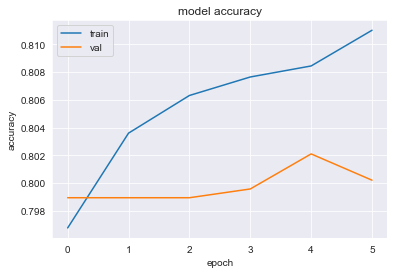

In [28]:
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

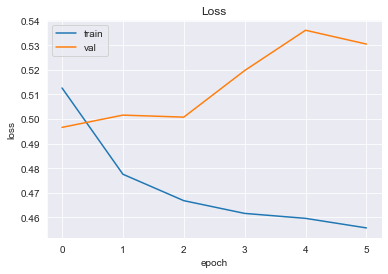

In [29]:
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

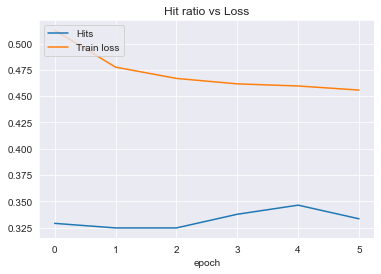

In [30]:
sns.set_style("darkgrid")
plt.plot(hits_list)
plt.plot(train_loss)
plt.title('Hit ratio vs Loss')
plt.xlabel('epoch')
plt.legend(['Hits', 'Train loss'], loc='upper left')
plt.show()

# 5. User profile evaluation

In [31]:
def get_article_category(article_id):
    return merged[merged["article_id"] == article_id]["subcategory_cleaned"].values[0]
def get_userprofile_to_name(user_id, id_to_subcategory):
    """
    Return array of strings with category names
    """
    arr_profile = get_user_profile(df_train,user_id )
    return [id_to_subcategory[elem] for elem in arr_profile]
def get_user_profile(df, user_id):
    """
    Return the user profile given user_id
    """
    return df[df["user_id"] == user_id].iloc[0, 1:7].values
def get_article_content(article_id):
    article = merged[merged["article_id"] == article_id].head(1)
    title = article["title"].values[0]
    sub_category = article["sub_category"].values[0]
    return title, sub_category

def get_item_features(user_id):
    d = df_test[df_test["user_id"] == user_id]
    return d["category"].values.reshape(-1,1), d["sub_category"].values.reshape(-1,1)

def get_item_features_one_item(article_id):
    d = df_test[df_test["article_id"] == article_id]
    return np.array(d["category"].values[0]), np.array(d["sub_category"].values[0])

In [52]:
def get_recommendations(user_id, df):
    #user_history, profile_input, item_input,category_input, subcategory_input
    ## Setup ###
    click_history = userid_to_article_history[user_id]
    user_profile = get_user_profile(df, user_id)
    display_items = df[df["user_id"] == user_id]["article_id"].values.reshape(-1, 1).astype("int64")
    user_profile = np.tile(user_profile, display_items.shape[0]).reshape(-1, 6).astype("int64")
    category, sub_category = get_item_features(user_id)
    click_history = np.tile(np.array(click_history), display_items.shape[0]).reshape(-1,30).astype("int64")
    category = np.asarray(category).astype("int64")
    sub_category = np.asarray(sub_category).astype("int64")
    #category = np.tile(category, display_items.shape[0]).reshape(-1,1).astype("int64")
    #sub_category = np.tile(sub_category, display_items.shape[0]).reshape(-1,1).astype("int64")
    
    ## Preds ###
    predictions = model.predict([click_history, user_profile, display_items, category, sub_category])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [display_items[i][0] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    return top_ten_items



In [50]:
def get_article_category(article_id, df):
    """
    Return the article's category
        type: int
    """
    return df[df["article_id"] == article_id]["category"].values[0]
def get_article_subcategory(article_id, df):
    """
    Return the article's category
        type: int
    """
    return df[df["article_id"] == article_id]["sub_category"].values[0]
def get_category_hit_ratio(user_profile, top_ten_categories):
    for profile in user_profile:
        for category in top_ten_categories:
            if profile == category:
                return 1
    return 0
def get_ndcgs_category(user_profile, top_ten_categories):
    for i in range(len(top_ten_categories)):
        item = top_ten_categories[i]
        for profile in user_profile:
            if item == profile:
                return math.log(2) / math.log(i+2)
    return 0

In [51]:
def predict_all_users(df):
    hits_ten,ndcgs_ten = [], []
    hits_five, ndcgs_five = [], []
    counter = 0
    for user_id in tqdm(df["user_id"].unique()):
        top_ten_articles = get_recommendations(user_id, df)
        assert len(top_ten_articles) == 10
        top_ten_subcategories = [get_article_subcategory(_id, df) for _id in top_ten_articles]
        user_profile = get_user_profile(df_test, user_id)

        hit_ten = get_category_hit_ratio(user_profile, top_ten_subcategories)
        ndcg_ten = get_ndcgs_category(user_profile, top_ten_subcategories)
        
        hit_five = get_category_hit_ratio(user_profile, top_ten_subcategories[:5])
        ndcg_five = get_ndcgs_category(user_profile, top_ten_subcategories[:5])
        
        hits_ten.append(hit_ten)
        ndcgs_ten.append(ndcg_ten)
        hits_five.append(hit_five)
        ndcgs_five.append(ndcg_five)
        counter += 1
    return np.average(hits_ten), np.average(ndcgs_ten), np.average(hits_five), np.average(ndcgs_five)
        
        
category_hits_ten, category_ndcg_ten,category_hits_five,category_ndcg_five   = predict_all_users(df_test)

  1%|▏         | 3/231 [00:00<00:20, 11.30it/s]

[[0.05191785]
 [0.12020186]
 [0.10312378]
 [0.09080443]
 [0.16752261]
 [0.08248684]
 [0.1774258 ]
 [0.12806398]
 [0.10710669]
 [0.21937674]
 [0.07986107]
 [0.095732  ]
 [0.1613026 ]
 [0.06801835]
 [0.19487679]
 [0.06218058]
 [0.1127052 ]
 [0.1215755 ]
 [0.16797885]
 [0.08304614]
 [0.25070912]
 [0.18098596]
 [0.5353232 ]
 [0.1133824 ]
 [0.12348494]
 [0.19445428]
 [0.13207945]
 [0.22362065]
 [0.0975115 ]
 [0.76293856]
 [0.11632696]
 [0.09373784]
 [0.1120657 ]
 [0.1657621 ]
 [0.1249913 ]
 [0.17240986]
 [0.1224432 ]
 [0.10954526]
 [0.13507721]
 [0.33331472]
 [0.2730263 ]
 [0.03659198]
 [0.20959774]
 [0.10974014]
 [0.33687568]
 [0.216405  ]
 [0.15053049]
 [0.14712918]
 [0.1443559 ]
 [0.21919101]
 [0.11632478]
 [0.13052306]
 [0.08568493]
 [0.07437506]
 [0.12497243]
 [0.12053531]
 [0.15004766]
 [0.15440032]
 [0.09806967]
 [0.20824578]
 [0.21532357]
 [0.15003377]
 [0.20175308]
 [0.18085134]
 [0.10678592]
 [0.12722987]
 [0.1611771 ]
 [0.16218144]
 [0.08206701]
 [0.09758312]
 [0.1517793 ]
 [0.24

  2%|▏         | 5/231 [00:00<00:19, 11.75it/s]

[[0.04785311]
 [0.1139963 ]
 [0.03553095]
 [0.10357907]
 [0.21504933]
 [0.26620024]
 [0.10471588]
 [0.06271109]
 [0.22806698]
 [0.12206867]
 [0.13789621]
 [0.1652163 ]
 [0.07189268]
 [0.10661113]
 [0.0822905 ]
 [0.0719128 ]
 [0.12265247]
 [0.1358743 ]
 [0.15729842]
 [0.14189562]
 [0.08101365]
 [0.4653662 ]
 [0.03731817]
 [0.14675543]
 [0.21117562]
 [0.0372808 ]
 [0.12153766]
 [0.10802102]
 [0.08650136]
 [0.13729924]
 [0.05225167]
 [0.28536186]
 [0.21346533]
 [0.12303078]
 [0.0620307 ]
 [0.09614375]
 [0.14749584]
 [0.12836269]
 [0.0853487 ]
 [0.07291308]
 [0.14749461]
 [0.08724856]
 [0.15196747]
 [0.1531345 ]
 [0.28790456]
 [0.15129045]
 [0.16644827]
 [0.08259019]
 [0.05251819]
 [0.14232707]
 [0.1375325 ]
 [0.03143528]
 [0.04562593]
 [0.11735675]
 [0.17852014]
 [0.11830434]
 [0.27080643]
 [0.09314629]
 [0.09044114]
 [0.03658277]
 [0.08070144]
 [0.10223442]
 [0.39018065]
 [0.26620024]
 [0.18892631]
 [0.17533591]
 [0.11555848]
 [0.08220512]
 [0.15750256]
 [0.11683148]
 [0.08023214]
 [0.26

  4%|▍         | 9/231 [00:00<00:17, 12.34it/s]

[[0.2580719 ]
 [0.07955924]
 [0.1281153 ]
 [0.14116406]
 [0.07022825]
 [0.2774546 ]
 [0.18958685]
 [0.19273448]
 [0.19265476]
 [0.13167861]
 [0.10694462]
 [0.03802514]
 [0.21229452]
 [0.29348633]
 [0.2020688 ]
 [0.12934452]
 [0.10315689]
 [0.1178751 ]
 [0.09485221]
 [0.10662812]
 [0.17503026]
 [0.11975074]
 [0.15051934]
 [0.10537848]
 [0.12044287]
 [0.15228865]
 [0.03918204]
 [0.08998337]
 [0.12952948]
 [0.12741065]
 [0.21693897]
 [0.12971643]
 [0.21119681]
 [0.10049224]
 [0.14182672]
 [0.11174747]
 [0.11303225]
 [0.1667346 ]
 [0.07230794]
 [0.15941143]
 [0.08222625]
 [0.10221928]
 [0.09814766]
 [0.10077515]
 [0.07828951]
 [0.10927817]
 [0.1819683 ]
 [0.13750884]
 [0.10611147]
 [0.1693173 ]
 [0.12188542]
 [0.13362533]
 [0.06021836]
 [0.25429708]
 [0.03096923]
 [0.11430246]
 [0.06444731]
 [0.15373436]
 [0.15346247]
 [0.11622748]
 [0.21353939]
 [0.3107794 ]
 [0.15637037]
 [0.12695587]
 [0.17563218]
 [0.12099311]
 [0.06189385]
 [0.12357128]
 [0.1641398 ]
 [0.21668121]
 [0.1517618 ]
 [0.14

  5%|▍         | 11/231 [00:00<00:17, 12.39it/s]

[[0.05781901]
 [0.14248982]
 [0.05982426]
 [0.09035575]
 [0.10300523]
 [0.14019194]
 [0.21839195]
 [0.30021235]
 [0.14492247]
 [0.1063191 ]
 [0.09169263]
 [0.187332  ]
 [0.10455424]
 [0.11756349]
 [0.08791927]
 [0.10948205]
 [0.23829561]
 [0.27066824]
 [0.210311  ]
 [0.13589129]
 [0.14457485]
 [0.09757268]
 [0.21982056]
 [0.04750818]
 [0.12239817]
 [0.11929202]
 [0.32728046]
 [0.11533341]
 [0.32623446]
 [0.11819774]
 [0.15103704]
 [0.12293515]
 [0.11125857]
 [0.0744476 ]
 [0.14371994]
 [0.23351088]
 [0.20696437]
 [0.11050349]
 [0.13306516]
 [0.20712459]
 [0.16598806]
 [0.19881281]
 [0.24113214]
 [0.13102555]
 [0.11603904]
 [0.18291825]
 [0.05318633]
 [0.05271763]
 [0.08788526]
 [0.1598315 ]
 [0.1450761 ]
 [0.21892321]
 [0.17693055]
 [0.07232276]
 [0.13823402]
 [0.44240874]
 [0.0935846 ]
 [0.23222122]
 [0.21409461]
 [0.15765163]
 [0.10185975]
 [0.10385588]
 [0.08267403]
 [0.22869143]
 [0.04628238]
 [0.21854445]
 [0.10670465]
 [0.17581919]
 [0.08367166]
 [0.10688049]
 [0.21465957]
 [0.25

  6%|▋         | 15/231 [00:01<00:17, 12.65it/s]

[[0.37680063]
 [0.15908653]
 [0.10030562]
 [0.23375148]
 [0.11291033]
 [0.08978701]
 [0.0741246 ]
 [0.10790387]
 [0.10049489]
 [0.17431024]
 [0.20105991]
 [0.09519178]
 [0.14276719]
 [0.2195057 ]
 [0.10896927]
 [0.08748782]
 [0.11224046]
 [0.2170139 ]
 [0.2615763 ]
 [0.11105183]
 [0.18159041]
 [0.1351541 ]
 [0.09826833]
 [0.18268907]
 [0.10804513]
 [0.12574795]
 [0.1236158 ]
 [0.10647166]
 [0.14392677]
 [0.1439004 ]
 [0.0488359 ]
 [0.10342166]
 [0.16639888]
 [0.14194146]
 [0.15587354]
 [0.15149078]
 [0.17195114]
 [0.17238232]
 [0.18159041]
 [0.29814494]
 [0.09089804]
 [0.07815012]
 [0.12204659]
 [0.52417123]
 [0.14142406]
 [0.12150127]
 [0.1667611 ]
 [0.0740332 ]
 [0.13773888]
 [0.16316879]
 [0.1488559 ]
 [0.11969966]
 [0.13053897]
 [0.14492929]
 [0.1083788 ]
 [0.08920139]
 [0.1637392 ]
 [0.14462614]
 [0.11883527]
 [0.22092196]
 [0.03560212]
 [0.23516622]
 [0.12442422]
 [0.10913518]
 [0.22158995]
 [0.14944217]
 [0.18945149]
 [0.13680169]
 [0.09818825]
 [0.30889177]
 [0.3085354 ]
 [0.04

  7%|▋         | 17/231 [00:01<00:17, 12.15it/s]

[[0.23083884]
 [0.19049785]
 [0.09098691]
 [0.10803464]
 [0.12439984]
 [0.18556643]
 [0.12636039]
 [0.14028871]
 [0.09708318]
 [0.14522433]
 [0.21393862]
 [0.3352303 ]
 [0.1076507 ]
 [0.13005269]
 [0.22637075]
 [0.24456638]
 [0.09344411]
 [0.23832813]
 [0.1026929 ]
 [0.23895782]
 [0.14133933]
 [0.07636687]
 [0.03933689]
 [0.0833286 ]
 [0.09280774]
 [0.04866385]
 [0.204792  ]
 [0.12940857]
 [0.05194813]
 [0.12289274]
 [0.10696405]
 [0.12705857]
 [0.17047364]
 [0.09204352]
 [0.18536457]
 [0.05691591]
 [0.10690331]
 [0.12017477]
 [0.10773709]
 [0.29430294]
 [0.08087516]
 [0.13726875]
 [0.11577716]
 [0.13376188]
 [0.25090033]
 [0.11700583]
 [0.16981754]
 [0.08737537]
 [0.11009678]
 [0.04455513]
 [0.12858057]
 [0.20374799]
 [0.07329828]
 [0.28896382]
 [0.14170879]
 [0.11581376]
 [0.13007751]
 [0.17546874]
 [0.30873805]
 [0.04965687]
 [0.10304683]
 [0.1358402 ]
 [0.14223874]
 [0.07067344]
 [0.11426166]
 [0.18935266]
 [0.20123342]
 [0.17553684]
 [0.06572202]
 [0.14162433]
 [0.2345143 ]
 [0.09

  8%|▊         | 19/231 [00:01<00:17, 11.82it/s]

[[0.04621726]
 [0.19135046]
 [0.04963654]
 [0.15015095]
 [0.12199342]
 [0.13928792]
 [0.17079043]
 [0.10899413]
 [0.09891343]
 [0.12181026]
 [0.2422154 ]
 [0.04826993]
 [0.12300402]
 [0.11912507]
 [0.06005284]
 [0.10144982]
 [0.11738205]
 [0.22776958]
 [0.04312766]
 [0.1585818 ]
 [0.09433794]
 [0.1180661 ]
 [0.20641616]
 [0.16489977]
 [0.09918681]
 [0.29522943]
 [0.15240276]
 [0.07044119]
 [0.11359829]
 [0.09862155]
 [0.13111407]
 [0.10553658]
 [0.11933255]
 [0.05580279]
 [0.37048995]
 [0.43819177]
 [0.2051971 ]
 [0.1327258 ]
 [0.33059478]
 [0.11236688]
 [0.16969621]
 [0.09561333]
 [0.12110916]
 [0.10832083]
 [0.13461122]
 [0.15280676]
 [0.04752314]
 [0.3028854 ]
 [0.26368225]
 [0.2880355 ]
 [0.16853142]
 [0.07773864]
 [0.23359135]
 [0.11499104]
 [0.12363052]
 [0.18587819]
 [0.1130093 ]
 [0.10621381]
 [0.06836295]
 [0.05377063]
 [0.06374505]
 [0.13410825]
 [0.1607196 ]
 [0.23779577]
 [0.1361844 ]
 [0.10491586]
 [0.6765071 ]
 [0.13287878]
 [0.3872096 ]
 [0.11236688]
 [0.15141001]
 [0.11

 10%|▉         | 23/231 [00:01<00:18, 11.54it/s]

[[0.3334589 ]
 [0.08388025]
 [0.22447449]
 [0.13810468]
 [0.10329935]
 [0.15265238]
 [0.17944387]
 [0.19054121]
 [0.29832962]
 [0.09040892]
 [0.12740844]
 [0.1244809 ]
 [0.24472702]
 [0.10344303]
 [0.18369296]
 [0.08108872]
 [0.19176957]
 [0.06133175]
 [0.04673579]
 [0.08307961]
 [0.14643073]
 [0.11415693]
 [0.21277338]
 [0.05404094]
 [0.1148715 ]
 [0.09234995]
 [0.10705966]
 [0.2774153 ]
 [0.26640436]
 [0.21060088]
 [0.1927382 ]
 [0.10105333]
 [0.316949  ]
 [0.12369135]
 [0.16920975]
 [0.10709608]
 [0.08913407]
 [0.35675526]
 [0.14387462]
 [0.12133509]
 [0.19401357]
 [0.30905408]
 [0.18363976]
 [0.08350456]
 [0.07396057]
 [0.10090235]
 [0.18637249]
 [0.16539595]
 [0.09878203]
 [0.10987881]
 [0.18857822]
 [0.08345842]
 [0.14160159]
 [0.08066195]
 [0.08758658]
 [0.10781971]
 [0.19491878]
 [0.15986627]
 [0.2472763 ]
 [0.15581018]
 [0.12335867]
 [0.09379992]
 [0.22084877]
 [0.12982872]
 [0.13843945]
 [0.04077831]
 [0.18045166]
 [0.06948757]
 [0.21719256]
 [0.09902292]
 [0.07631457]
 [0.15

 12%|█▏        | 27/231 [00:02<00:16, 12.02it/s]

[[0.2929067 ]
 [0.11922401]
 [0.19891703]
 [0.17929032]
 [0.7131924 ]
 [0.13115   ]
 [0.123308  ]
 [0.12509868]
 [0.08889517]
 [0.07911041]
 [0.11435869]
 [0.09153455]
 [0.23153141]
 [0.12385705]
 [0.16784093]
 [0.12614754]
 [0.08170715]
 [0.1367591 ]
 [0.07728547]
 [0.18777412]
 [0.36290795]
 [0.05881727]
 [0.09610146]
 [0.10792106]
 [0.06908342]
 [0.11268616]
 [0.11385688]
 [0.04589263]
 [0.08527645]
 [0.19842616]
 [0.09564993]
 [0.11529702]
 [0.10219908]
 [0.06785625]
 [0.11649668]
 [0.36865982]
 [0.36801755]
 [0.07430151]
 [0.26827097]
 [0.27136517]
 [0.08183941]
 [0.10732767]
 [0.39966944]
 [0.09764749]
 [0.05754706]
 [0.13999343]
 [0.13076961]
 [0.12787306]
 [0.09239727]
 [0.14014128]
 [0.08121645]
 [0.09630549]
 [0.16755712]
 [0.09487751]
 [0.1907556 ]
 [0.16419265]
 [0.11241806]
 [0.12300074]
 [0.21891871]
 [0.5608396 ]
 [0.09880283]
 [0.1813651 ]
 [0.13991347]
 [0.27359867]
 [0.18872517]
 [0.16310042]
 [0.13494554]
 [0.27733755]
 [0.29838747]
 [0.19443986]
 [0.10114038]
 [0.09

 13%|█▎        | 29/231 [00:02<00:16, 12.02it/s]

[[0.53527457]
 [0.13213491]
 [0.13436988]
 [0.07900676]
 [0.1286279 ]
 [0.30104157]
 [0.25195074]
 [0.09929416]
 [0.15586281]
 [0.15678227]
 [0.16337034]
 [0.16232723]
 [0.22548622]
 [0.12599936]
 [0.08500916]
 [0.1008912 ]
 [0.27923703]
 [0.10620195]
 [0.21019804]
 [0.12892643]
 [0.24920934]
 [0.1387325 ]
 [0.18361986]
 [0.10604781]
 [0.14260074]
 [0.09524161]
 [0.07363299]
 [0.09897023]
 [0.09813759]
 [0.097532  ]
 [0.12865287]
 [0.25424755]
 [0.04895639]
 [0.2260071 ]
 [0.10506746]
 [0.11432588]
 [0.25274205]
 [0.21150538]
 [0.08612677]
 [0.27570623]
 [0.11808541]
 [0.14413062]
 [0.10823244]
 [0.09370896]
 [0.29425883]
 [0.08208942]
 [0.04119992]
 [0.06297266]
 [0.12728542]
 [0.14442044]
 [0.2769997 ]
 [0.10023773]
 [0.07494071]
 [0.15724367]
 [0.13832667]
 [0.20542544]
 [0.1015394 ]
 [0.15317756]
 [0.18606082]
 [0.12565014]
 [0.09185109]
 [0.07436326]
 [0.13226607]
 [0.04148909]
 [0.14528307]
 [0.13050085]
 [0.23702869]
 [0.14902794]
 [0.08418295]
 [0.12422979]
 [0.08251685]
 [0.13

 14%|█▍        | 33/231 [00:02<00:16, 12.20it/s]

[[0.05245835]
 [0.30010724]
 [0.07358867]
 [0.05178127]
 [0.15947878]
 [0.16010642]
 [0.08309197]
 [0.16440007]
 [0.11396986]
 [0.12901357]
 [0.24911615]
 [0.09684163]
 [0.13610807]
 [0.09942627]
 [0.1742937 ]
 [0.05002549]
 [0.12248155]
 [0.12424153]
 [0.14871836]
 [0.11353824]
 [0.17213994]
 [0.22173226]
 [0.10417694]
 [0.36148712]
 [0.18152836]
 [0.12085861]
 [0.19147938]
 [0.25883678]
 [0.18310493]
 [0.10698065]
 [0.24550855]
 [0.12691554]
 [0.03418231]
 [0.29823026]
 [0.09247246]
 [0.11658353]
 [0.10787719]
 [0.15306899]
 [0.1526835 ]
 [0.18404442]
 [0.22256279]
 [0.11512408]
 [0.08554268]
 [0.09568667]
 [0.08415839]
 [0.24178529]
 [0.10883573]
 [0.10744557]
 [0.06100506]
 [0.15376243]
 [0.17656377]
 [0.10859054]
 [0.07370448]
 [0.03440145]
 [0.21543571]
 [0.1576905 ]
 [0.10449281]
 [0.15376243]
 [0.11658353]
 [0.10588565]
 [0.18791926]
 [0.10917425]
 [0.11682332]
 [0.10820997]
 [0.21520257]
 [0.10036176]
 [0.12445483]
 [0.0832254 ]
 [0.18353331]
 [0.12420467]
 [0.11619258]
 [0.16

 15%|█▌        | 35/231 [00:02<00:16, 11.57it/s]

[[0.37160438]
 [0.1251424 ]
 [0.09441075]
 [0.1733813 ]
 [0.1527558 ]
 [0.18765801]
 [0.09823519]
 [0.10317734]
 [0.08657417]
 [0.1917547 ]
 [0.246503  ]
 [0.08635387]
 [0.18131456]
 [0.11207268]
 [0.17593819]
 [0.1209105 ]
 [0.13862425]
 [0.10340282]
 [0.10069677]
 [0.15598303]
 [0.23181576]
 [0.23645094]
 [0.1748375 ]
 [0.07295829]
 [0.09127495]
 [0.22839105]
 [0.12828013]
 [0.17792404]
 [0.26124233]
 [0.09392875]
 [0.09599754]
 [0.11929432]
 [0.12848854]
 [0.11826801]
 [0.1261355 ]
 [0.07584357]
 [0.23164818]
 [0.14239869]
 [0.12691307]
 [0.0656606 ]
 [0.12120554]
 [0.1188297 ]
 [0.12237072]
 [0.05951679]
 [0.11914453]
 [0.16737917]
 [0.09329876]
 [0.1257787 ]
 [0.73693115]
 [0.0857071 ]
 [0.3868401 ]
 [0.1399354 ]
 [0.03493524]
 [0.11284247]
 [0.49472776]
 [0.23452196]
 [0.17905298]
 [0.15663806]
 [0.23298156]
 [0.07443622]
 [0.06834444]
 [0.10527745]
 [0.11965686]
 [0.10300416]
 [0.2659304 ]
 [0.30168396]
 [0.1340577 ]
 [0.13058889]
 [0.08418238]
 [0.0466114 ]
 [0.23298222]
 [0.30

 17%|█▋        | 39/231 [00:03<00:17, 10.71it/s]

[[0.09495947]
 [0.1034964 ]
 [0.22178048]
 [0.04723743]
 [0.14931327]
 [0.1109643 ]
 [0.11572894]
 [0.12404701]
 [0.19910693]
 [0.11467254]
 [0.10875985]
 [0.13453922]
 [0.05896828]
 [0.24567923]
 [0.11664096]
 [0.11463049]
 [0.45883292]
 [0.2007344 ]
 [0.11673376]
 [0.7062211 ]
 [0.32975918]
 [0.11234844]
 [0.10438502]
 [0.17990243]
 [0.34118396]
 [0.17655364]
 [0.08396086]
 [0.27798745]
 [0.18675414]
 [0.32134753]
 [0.04705027]
 [0.13845634]
 [0.30910024]
 [0.11292511]
 [0.11406693]
 [0.11047557]
 [0.12840012]
 [0.5200403 ]
 [0.4464999 ]
 [0.16380474]
 [0.15130761]
 [0.13062868]
 [0.21774513]
 [0.12827033]
 [0.22206128]
 [0.15444487]
 [0.15754989]
 [0.19913396]
 [0.11550942]
 [0.09655526]
 [0.10108492]
 [0.28215003]
 [0.31926453]
 [0.1931372 ]
 [0.17560852]
 [0.08035079]
 [0.12166274]
 [0.15051386]
 [0.13367686]
 [0.12362793]
 [0.37081194]
 [0.19160405]
 [0.13433674]
 [0.08439359]
 [0.1218673 ]
 [0.15184933]
 [0.11293596]
 [0.10384831]
 [0.1457083 ]
 [0.12844732]
 [0.16677418]
 [0.15

 18%|█▊        | 41/231 [00:03<00:18, 10.45it/s]

[[0.04729435]
 [0.34024987]
 [0.08383915]
 [0.12255055]
 [0.11950105]
 [0.13313285]
 [0.22751832]
 [0.09339866]
 [0.10856819]
 [0.28474563]
 [0.0664486 ]
 [0.15022999]
 [0.10037789]
 [0.11231914]
 [0.17684415]
 [0.1823959 ]
 [0.1502051 ]
 [0.11837089]
 [0.22280896]
 [0.11073601]
 [0.11811501]
 [0.13051033]
 [0.3161111 ]
 [0.21205032]
 [0.16756609]
 [0.07260284]
 [0.11234888]
 [0.05175656]
 [0.120992  ]
 [0.12514976]
 [0.13089302]
 [0.11483601]
 [0.11060834]
 [0.13031965]
 [0.07842779]
 [0.06971928]
 [0.04776973]
 [0.0933651 ]
 [0.1071921 ]
 [0.10811141]
 [0.25450987]
 [0.10158908]
 [0.20006385]
 [0.10125935]
 [0.12893769]
 [0.6179017 ]
 [0.11936611]
 [0.08863702]
 [0.13494167]
 [0.08437735]
 [0.13695589]
 [0.13307747]
 [0.28409386]
 [0.09381557]
 [0.07500228]
 [0.09526485]
 [0.06580254]
 [0.0868786 ]
 [0.1419251 ]
 [0.1701492 ]
 [0.23695764]
 [0.12432829]
 [0.14205495]
 [0.11560026]
 [0.06721041]
 [0.12780032]
 [0.13246575]
 [0.20088178]
 [0.30730528]
 [0.1008493 ]
 [0.04650605]
 [0.12

 19%|█▊        | 43/231 [00:03<00:17, 10.57it/s]

[[0.125848  ]
 [0.3685543 ]
 [0.16597596]
 [0.14809936]
 [0.27530766]
 [0.3826595 ]
 [0.24846181]
 [0.12046766]
 [0.11283505]
 [0.1095989 ]
 [0.11852664]
 [0.17215931]
 [0.10788852]
 [0.16687587]
 [0.1396136 ]
 [0.11498848]
 [0.09889275]
 [0.10840061]
 [0.15919313]
 [0.26411864]
 [0.09084314]
 [0.2922865 ]
 [0.23434371]
 [0.21352002]
 [0.09097043]
 [0.1087864 ]
 [0.14424267]
 [0.09783152]
 [0.10031518]
 [0.18542099]
 [0.20690024]
 [0.09022868]
 [0.09225085]
 [0.09012333]
 [0.10967341]
 [0.10763472]
 [0.10558212]
 [0.15693355]
 [0.1386643 ]
 [0.15501648]
 [0.10991937]
 [0.06303743]
 [0.08554399]
 [0.11261901]
 [0.06306762]
 [0.08900192]
 [0.05254161]
 [0.15006253]
 [0.15631503]
 [0.15819466]
 [0.20495525]
 [0.14421156]
 [0.19489995]
 [0.0543085 ]
 [0.28834724]
 [0.12631652]
 [0.1257956 ]
 [0.1505813 ]
 [0.15987849]
 [0.15823889]
 [0.13649902]
 [0.07968575]
 [0.34186012]
 [0.2660333 ]
 [0.15109184]
 [0.16645217]
 [0.13176799]
 [0.05695465]
 [0.28798193]
 [0.1627228 ]
 [0.33834743]
 [0.13

 20%|██        | 47/231 [00:04<00:16, 11.31it/s]

[[0.03951761]
 [0.18559226]
 [0.11558372]
 [0.11277923]
 [0.20341659]
 [0.14109081]
 [0.12535036]
 [0.11386415]
 [0.20537439]
 [0.10161057]
 [0.1253156 ]
 [0.16992232]
 [0.13971856]
 [0.08318588]
 [0.08213085]
 [0.04977596]
 [0.07918158]
 [0.14347109]
 [0.18026319]
 [0.22099164]
 [0.1415157 ]
 [0.12162328]
 [0.11731589]
 [0.21254951]
 [0.0860016 ]
 [0.20590788]
 [0.13349152]
 [0.13909784]
 [0.36065817]
 [0.08823702]
 [0.33965522]
 [0.12009364]
 [0.16864264]
 [0.10205069]
 [0.23479074]
 [0.15813807]
 [0.09683678]
 [0.19177705]
 [0.10999066]
 [0.09763822]
 [0.33253872]
 [0.7313755 ]
 [0.22419539]
 [0.108679  ]
 [0.40248784]
 [0.1905452 ]
 [0.51014036]
 [0.14038149]
 [0.2148233 ]
 [0.13560843]
 [0.1839062 ]
 [0.17710304]
 [0.11550045]
 [0.22108999]
 [0.11442876]
 [0.23989141]
 [0.10450849]
 [0.12424147]
 [0.12340987]
 [0.08373627]
 [0.10373884]
 [0.11463571]
 [0.09312403]
 [0.13650885]
 [0.04901731]
 [0.11680123]
 [0.11146113]
 [0.21370229]
 [0.10635549]
 [0.11219907]
 [0.13074061]
 [0.06

 22%|██▏       | 51/231 [00:04<00:15, 11.29it/s]

[[0.32766926]
 [0.05033016]
 [0.15481958]
 [0.166951  ]
 [0.07238403]
 [0.15906274]
 [0.16176784]
 [0.14095724]
 [0.11105135]
 [0.07682323]
 [0.08207926]
 [0.08768934]
 [0.04931697]
 [0.03000814]
 [0.32439646]
 [0.05133337]
 [0.25374663]
 [0.15373346]
 [0.09736112]
 [0.07071468]
 [0.09126073]
 [0.0811168 ]
 [0.21590945]
 [0.16351879]
 [0.14280179]
 [0.14327621]
 [0.20443505]
 [0.12501046]
 [0.33816442]
 [0.09995234]
 [0.14614522]
 [0.15090016]
 [0.08710045]
 [0.23570746]
 [0.17939329]
 [0.2610934 ]
 [0.12039629]
 [0.19495004]
 [0.12864906]
 [0.05612049]
 [0.1689643 ]
 [0.13904813]
 [0.13959372]
 [0.15107578]
 [0.04927695]
 [0.08177337]
 [0.10954013]
 [0.11717683]
 [0.10629201]
 [0.16558611]
 [0.19951716]
 [0.10085863]
 [0.14210579]
 [0.12578866]
 [0.08168313]
 [0.09885287]
 [0.08232468]
 [0.10591093]
 [0.09416744]
 [0.09615114]
 [0.16049385]
 [0.11021239]
 [0.11844748]
 [0.15780273]
 [0.06771836]
 [0.07389292]
 [0.08519429]
 [0.09136882]
 [0.0865317 ]
 [0.10542715]
 [0.1882756 ]
 [0.26

 23%|██▎       | 53/231 [00:04<00:16, 10.64it/s]

[[0.14318892]
 [0.13045111]
 [0.24867806]
 [0.10953462]
 [0.16763595]
 [0.2551883 ]
 [0.09685293]
 [0.4389663 ]
 [0.1664905 ]
 [0.26376158]
 [0.31603205]
 [0.11761966]
 [0.12348589]
 [0.2358163 ]
 [0.15642026]
 [0.48835838]
 [0.16953146]
 [0.19398466]
 [0.20050484]
 [0.13922873]
 [0.13869861]
 [0.16406754]
 [0.1720854 ]
 [0.27435255]
 [0.52702504]
 [0.13626224]
 [0.62777627]
 [0.30675066]
 [0.08239093]
 [0.20425138]
 [0.2736325 ]
 [0.42406842]
 [0.17005348]
 [0.18564391]
 [0.18583867]
 [0.23233968]
 [0.71269816]
 [0.29295802]
 [0.06874388]
 [0.10324302]
 [0.16778213]
 [0.21044695]
 [0.12620121]
 [0.09475854]
 [0.19392478]
 [0.11359787]
 [0.15800318]
 [0.1908221 ]
 [0.16914842]
 [0.20556822]
 [0.22243074]
 [0.09651384]
 [0.16550055]
 [0.488582  ]
 [0.2428985 ]
 [0.10462379]
 [0.23991236]
 [0.2589301 ]
 [0.28675503]
 [0.11327299]
 [0.05409697]
 [0.25969693]
 [0.15749657]
 [0.20107302]
 [0.4530167 ]
 [0.13189554]
 [0.15395987]
 [0.13210154]
 [0.19353795]
 [0.36772805]
 [0.19641897]
 [0.19

 25%|██▍       | 57/231 [00:05<00:16, 10.36it/s]

[[0.0953809 ]
 [0.16184047]
 [0.1365003 ]
 [0.25341356]
 [0.39255017]
 [0.09850648]
 [0.1017125 ]
 [0.13254216]
 [0.10999751]
 [0.10812703]
 [0.4527825 ]
 [0.21389201]
 [0.09322903]
 [0.1404342 ]
 [0.06847212]
 [0.11877578]
 [0.08199823]
 [0.17894545]
 [0.23212913]
 [0.05203295]
 [0.21883565]
 [0.21822846]
 [0.27148736]
 [0.14660323]
 [0.09643769]
 [0.06982315]
 [0.12806055]
 [0.15999672]
 [0.2455441 ]
 [0.16137648]
 [0.14744487]
 [0.0891223 ]
 [0.11252257]
 [0.14664024]
 [0.1189115 ]
 [0.08208191]
 [0.18290013]
 [0.13148698]
 [0.29834154]
 [0.13978028]
 [0.42277843]
 [0.18838999]
 [0.12365583]
 [0.17192373]
 [0.25521964]
 [0.10012326]
 [0.13932154]
 [0.0805206 ]
 [0.29702723]
 [0.12768021]
 [0.17142743]
 [0.24437171]
 [0.13679692]
 [0.07632855]
 [0.03771576]
 [0.19295979]
 [0.31857163]
 [0.09651983]
 [0.14576584]
 [0.13958403]
 [0.07358044]
 [0.11716923]
 [0.12735733]
 [0.06713811]
 [0.09365332]
 [0.20407683]
 [0.20309526]
 [0.15377876]
 [0.5421265 ]
 [0.1283072 ]
 [0.10308987]
 [0.14

 26%|██▌       | 59/231 [00:05<00:16, 10.21it/s]

[[0.34109104]
 [0.18862972]
 [0.28366253]
 [0.10494182]
 [0.17613602]
 [0.14857629]
 [0.12167275]
 [0.3230753 ]
 [0.11513478]
 [0.21908492]
 [0.1756376 ]
 [0.12250543]
 [0.11900297]
 [0.12291345]
 [0.11212426]
 [0.0992364 ]
 [0.11814564]
 [0.1169906 ]
 [0.13774192]
 [0.1476393 ]
 [0.12481314]
 [0.15724719]
 [0.16734806]
 [0.26784098]
 [0.1551773 ]
 [0.12671998]
 [0.47844133]
 [0.09744072]
 [0.11216304]
 [0.12678969]
 [0.11831939]
 [0.30118066]
 [0.10734159]
 [0.145742  ]
 [0.18723825]
 [0.3890709 ]
 [0.1202648 ]
 [0.0992541 ]
 [0.06118768]
 [0.15861881]
 [0.13344795]
 [0.2286272 ]
 [0.11854228]
 [0.2420117 ]
 [0.17134011]
 [0.11895707]
 [0.31270003]
 [0.17026883]
 [0.04834539]
 [0.19788045]
 [0.11924231]
 [0.18899667]
 [0.21961635]
 [0.12450042]
 [0.08992937]
 [0.19913179]
 [0.1210649 ]
 [0.18173504]
 [0.11057755]
 [0.11091095]
 [0.12528285]
 [0.15518174]
 [0.05831933]
 [0.11695746]
 [0.11239251]
 [0.19784918]
 [0.18044117]
 [0.17513072]
 [0.10059032]
 [0.11049324]
 [0.10461643]
 [0.21

 26%|██▋       | 61/231 [00:05<00:16, 10.21it/s]

[[0.5257747 ]
 [0.07755685]
 [0.1358543 ]
 [0.09560156]
 [0.10291353]
 [0.07609326]
 [0.08013034]
 [0.11589032]
 [0.12418917]
 [0.2994815 ]
 [0.18404502]
 [0.14741042]
 [0.11238575]
 [0.5206112 ]
 [0.08952063]
 [0.14908156]
 [0.11817327]
 [0.08784798]
 [0.02970868]
 [0.09758005]
 [0.10631794]
 [0.2226814 ]
 [0.1261403 ]
 [0.0471507 ]
 [0.16274008]
 [0.09267762]
 [0.14124247]
 [0.42897946]
 [0.2524717 ]
 [0.18648452]
 [0.09035751]
 [0.13681611]
 [0.12012711]
 [0.16501442]
 [0.18808928]
 [0.24876326]
 [0.11895829]
 [0.14201197]
 [0.28663158]
 [0.18575561]
 [0.13019711]
 [0.13288614]
 [0.12522322]
 [0.04137039]
 [0.07718518]
 [0.13746524]
 [0.24988028]
 [0.14615732]
 [0.08827746]
 [0.39031804]
 [0.09432784]
 [0.10723624]
 [0.25125766]
 [0.11591706]
 [0.11826101]
 [0.37097418]
 [0.14128557]
 [0.10366267]
 [0.30341968]
 [0.1923644 ]
 [0.10973334]
 [0.72565246]
 [0.09398478]
 [0.10594109]
 [0.1706382 ]
 [0.1036678 ]
 [0.22510076]
 [0.21308506]
 [0.05269435]
 [0.13692248]
 [0.04036072]
 [0.07

 28%|██▊       | 65/231 [00:05<00:16, 10.14it/s]

[[0.36268753]
 [0.07589251]
 [0.4363662 ]
 [0.11982536]
 [0.10909611]
 [0.1571813 ]
 [0.10566872]
 [0.12575844]
 [0.09110796]
 [0.08720705]
 [0.09383273]
 [0.17183903]
 [0.12419221]
 [0.09464276]
 [0.07390603]
 [0.13557991]
 [0.09297687]
 [0.15770343]
 [0.28086615]
 [0.10928589]
 [0.12633008]
 [0.07937562]
 [0.10957259]
 [0.10468262]
 [0.14138946]
 [0.10037839]
 [0.10200942]
 [0.17066139]
 [0.0428592 ]
 [0.0666779 ]
 [0.15339121]
 [0.11628178]
 [0.12131295]
 [0.12779975]
 [0.08973449]
 [0.12524313]
 [0.06993002]
 [0.03257334]
 [0.09366524]
 [0.13973325]
 [0.28002238]
 [0.07204744]
 [0.09993935]
 [0.35256767]
 [0.09393272]
 [0.16499013]
 [0.06995428]
 [0.1640946 ]
 [0.05555353]
 [0.08105254]
 [0.1414327 ]
 [0.11518309]
 [0.17856774]
 [0.25004733]
 [0.11464456]
 [0.18341836]
 [0.14675114]
 [0.18542361]
 [0.07072118]
 [0.382345  ]
 [0.13863376]
 [0.21343091]
 [0.23903161]
 [0.08882973]
 [0.09978077]
 [0.12027237]
 [0.04182878]
 [0.09080419]
 [0.16558346]
 [0.51809806]
 [0.14138946]
 [0.14

 30%|██▉       | 69/231 [00:06<00:15, 10.53it/s]

[[0.15754047]
 [0.15453759]
 [0.08079737]
 [0.1182884 ]
 [0.12026212]
 [0.13617676]
 [0.1994595 ]
 [0.11686316]
 [0.11989349]
 [0.6125522 ]
 [0.12270141]
 [0.09977821]
 [0.1516738 ]
 [0.09044069]
 [0.13702112]
 [0.21698579]
 [0.2087532 ]
 [0.19991305]
 [0.10517368]
 [0.19732505]
 [0.32247406]
 [0.04507503]
 [0.13602203]
 [0.11680925]
 [0.11485425]
 [0.24396661]
 [0.09237745]
 [0.13007715]
 [0.13689458]
 [0.16518515]
 [0.49002454]
 [0.21615008]
 [0.19922578]
 [0.07877961]
 [0.11517945]
 [0.16439518]
 [0.11686316]
 [0.12002349]
 [0.4685209 ]
 [0.04304808]
 [0.08838466]
 [0.22547463]
 [0.22094688]
 [0.10584679]
 [0.2075153 ]
 [0.14204213]
 [0.07001457]
 [0.13967547]
 [0.35127556]
 [0.15763587]
 [0.10088053]
 [0.0732536 ]
 [0.218638  ]
 [0.106361  ]
 [0.17726466]
 [0.28763503]
 [0.11592504]
 [0.18641943]
 [0.13997394]
 [0.08660877]
 [0.10231283]
 [0.24472818]
 [0.08803409]
 [0.24769214]
 [0.14888635]
 [0.28502885]
 [0.07309118]
 [0.07734939]
 [0.12213016]
 [0.27421963]
 [0.11928225]
 [0.15

 31%|███       | 71/231 [00:06<00:15, 10.39it/s]

[[0.20244169]
 [0.21439707]
 [0.23531625]
 [0.0557757 ]
 [0.12820268]
 [0.11897758]
 [0.10309348]
 [0.33013424]
 [0.1533271 ]
 [0.1046173 ]
 [0.10970694]
 [0.13902497]
 [0.09125125]
 [0.14125231]
 [0.23954508]
 [0.27683908]
 [0.10930434]
 [0.19002828]
 [0.1617172 ]
 [0.09702587]
 [0.7221401 ]
 [0.21368757]
 [0.18106619]
 [0.08233428]
 [0.21245691]
 [0.14432946]
 [0.08227131]
 [0.11787125]
 [0.03937548]
 [0.28007314]
 [0.03454286]
 [0.18576461]
 [0.17394522]
 [0.12000352]
 [0.22042888]
 [0.1322214 ]
 [0.09049118]
 [0.13460955]
 [0.12867045]
 [0.10749027]
 [0.13572788]
 [0.12183306]
 [0.11129695]
 [0.14200476]
 [0.11252731]
 [0.50445044]
 [0.17289841]
 [0.0389396 ]
 [0.08813548]
 [0.20120227]
 [0.38354173]
 [0.10324675]
 [0.10836855]
 [0.05846792]
 [0.29688945]
 [0.03138179]
 [0.11435416]
 [0.20050582]
 [0.12489384]
 [0.12843615]
 [0.16492724]
 [0.16643941]
 [0.08766019]
 [0.09772572]
 [0.0984762 ]
 [0.17042619]
 [0.29965696]
 [0.1146417 ]
 [0.11435416]
 [0.09584191]
 [0.17071366]
 [0.28

 32%|███▏      | 75/231 [00:06<00:15, 10.32it/s]

[[0.33100384]
 [0.12442413]
 [0.10626301]
 [0.11325556]
 [0.06068888]
 [0.12392157]
 [0.09602433]
 [0.14980873]
 [0.14351755]
 [0.11080787]
 [0.22869751]
 [0.12220958]
 [0.09717828]
 [0.23560706]
 [0.10643271]
 [0.12327662]
 [0.06389093]
 [0.0959768 ]
 [0.12596753]
 [0.04527804]
 [0.11268285]
 [0.31029826]
 [0.13204715]
 [0.03665221]
 [0.08755851]
 [0.33196482]
 [0.12426504]
 [0.11938986]
 [0.2203829 ]
 [0.12876403]
 [0.20211434]
 [0.12862155]
 [0.07536939]
 [0.27581537]
 [0.2423391 ]
 [0.17682108]
 [0.20974138]
 [0.18942049]
 [0.17275763]
 [0.18119782]
 [0.0873872 ]
 [0.15530899]
 [0.12192696]
 [0.09278637]
 [0.07644707]
 [0.14674723]
 [0.28038865]
 [0.20513797]
 [0.15152344]
 [0.04734927]
 [0.2219575 ]
 [0.10866439]
 [0.10310027]
 [0.09453762]
 [0.10452172]
 [0.08561757]
 [0.12446511]
 [0.17437056]
 [0.19988003]
 [0.09495583]
 [0.10533932]
 [0.04552624]
 [0.23336557]
 [0.07784641]
 [0.44011775]
 [0.05936867]
 [0.15203908]
 [0.15966073]
 [0.10665396]
 [0.15415877]
 [0.10825557]
 [0.17

 33%|███▎      | 77/231 [00:06<00:14, 10.28it/s]

[[0.12126675]
 [0.20316517]
 [0.18704847]
 [0.09867686]
 [0.09064537]
 [0.11466244]
 [0.12055418]
 [0.11047485]
 [0.10342625]
 [0.09890473]
 [0.14869612]
 [0.09599924]
 [0.08500287]
 [0.16499528]
 [0.14256707]
 [0.12302101]
 [0.11201522]
 [0.08111656]
 [0.11313477]
 [0.5214193 ]
 [0.03894579]
 [0.07865268]
 [0.07865268]
 [0.2888259 ]
 [0.20099762]
 [0.06472489]
 [0.12552351]
 [0.06507549]
 [0.07724589]
 [0.12150374]
 [0.1998361 ]
 [0.15508103]
 [0.16450328]
 [0.10304087]
 [0.07306728]
 [0.23883149]
 [0.1145345 ]
 [0.20934543]
 [0.17146242]
 [0.19917247]
 [0.13447988]
 [0.16798136]
 [0.12401897]
 [0.17837241]
 [0.118691  ]
 [0.11842525]
 [0.09110531]
 [0.08694834]
 [0.42526525]
 [0.39411408]
 [0.13017145]
 [0.09778032]
 [0.10900068]
 [0.10156155]
 [0.18678936]
 [0.08954069]
 [0.04212481]
 [0.09359008]
 [0.09006765]
 [0.18507463]
 [0.2590397 ]
 [0.24967584]
 [0.12774768]
 [0.12487009]
 [0.10220578]
 [0.11868042]
 [0.37114966]
 [0.17720929]
 [0.1994665 ]
 [0.3312992 ]
 [0.12896633]
 [0.10

 34%|███▍      | 79/231 [00:07<00:14, 10.25it/s]

[[0.03173527]
 [0.19332007]
 [0.12435874]
 [0.14153701]
 [0.19757622]
 [0.14984518]
 [0.0976465 ]
 [0.07257009]
 [0.11494049]
 [0.09272456]
 [0.13829961]
 [0.15338239]
 [0.15264276]
 [0.15426013]
 [0.14068118]
 [0.12458476]
 [0.15570557]
 [0.11236611]
 [0.04882738]
 [0.11333364]
 [0.10844469]
 [0.10665882]
 [0.18282306]
 [0.3593042 ]
 [0.29928017]
 [0.05385154]
 [0.26305023]
 [0.3341996 ]
 [0.10285676]
 [0.3435687 ]
 [0.05787122]
 [0.295451  ]
 [0.098474  ]
 [0.1112757 ]
 [0.19269991]
 [0.16226304]
 [0.13141936]
 [0.0929462 ]
 [0.06621727]
 [0.09935844]
 [0.15769398]
 [0.06253913]
 [0.1761499 ]
 [0.42660433]
 [0.0854204 ]
 [0.12219286]
 [0.04317474]
 [0.1456249 ]
 [0.2727474 ]
 [0.14826846]
 [0.13611585]
 [0.09879413]
 [0.14483395]
 [0.05283999]
 [0.10390404]
 [0.31339842]
 [0.09916759]
 [0.11236611]
 [0.10948989]
 [0.11422563]
 [0.04222247]
 [0.03682101]
 [0.10530117]
 [0.21817645]
 [0.1129562 ]
 [0.27909893]
 [0.18403652]
 [0.18721077]
 [0.08396512]
 [0.16273373]
 [0.3245568 ]
 [0.09

 36%|███▌      | 83/231 [00:07<00:14, 10.18it/s]

[[0.42893273]
 [0.0806762 ]
 [0.24024984]
 [0.30272263]
 [0.21700794]
 [0.10436025]
 [0.31558478]
 [0.12674662]
 [0.09349132]
 [0.08041146]
 [0.17262045]
 [0.19030678]
 [0.07774991]
 [0.12485182]
 [0.19605953]
 [0.0902051 ]
 [0.12704003]
 [0.19573069]
 [0.19487256]
 [0.15769172]
 [0.1496365 ]
 [0.14018556]
 [0.11765587]
 [0.14015535]
 [0.08631071]
 [0.2162525 ]
 [0.11644435]
 [0.29670495]
 [0.1797159 ]
 [0.13757676]
 [0.10619086]
 [0.10123098]
 [0.3335302 ]
 [0.14149955]
 [0.1691317 ]
 [0.185209  ]
 [0.09551507]
 [0.21500984]
 [0.14110446]
 [0.3475917 ]
 [0.10071555]
 [0.09169394]
 [0.12834233]
 [0.14303887]
 [0.12278113]
 [0.06495428]
 [0.08928013]
 [0.10915381]
 [0.12721044]
 [0.06289259]
 [0.14466494]
 [0.1046257 ]
 [0.09844595]
 [0.1470797 ]
 [0.16334188]
 [0.45462295]
 [0.11642918]
 [0.03983068]
 [0.09681964]
 [0.15204772]
 [0.45002317]
 [0.08988962]
 [0.10787809]
 [0.36181498]
 [0.0883432 ]
 [0.13756323]
 [0.10502678]
 [0.09473205]
 [0.33326656]
 [0.14769834]
 [0.28661734]
 [0.05

 37%|███▋      | 85/231 [00:07<00:14, 10.15it/s]

[[0.69479924]
 [0.14836878]
 [0.0751839 ]
 [0.13891244]
 [0.07852036]
 [0.10120389]
 [0.10436469]
 [0.09903812]
 [0.1331195 ]
 [0.13829073]
 [0.08628869]
 [0.07483342]
 [0.17165002]
 [0.15105882]
 [0.39686027]
 [0.18435538]
 [0.117044  ]
 [0.17056796]
 [0.18601763]
 [0.13149092]
 [0.08745688]
 [0.17449662]
 [0.28427434]
 [0.08327341]
 [0.04740906]
 [0.11431509]
 [0.1606709 ]
 [0.06903335]
 [0.21321493]
 [0.0995402 ]
 [0.0788531 ]
 [0.10431835]
 [0.0815548 ]
 [0.17319271]
 [0.07297307]
 [0.12100506]
 [0.17165002]
 [0.12169024]
 [0.10723692]
 [0.23253292]
 [0.12456241]
 [0.10274374]
 [0.09320912]
 [0.3455181 ]
 [0.16994774]
 [0.03671527]
 [0.15915602]
 [0.08838087]
 [0.07594457]
 [0.10842294]
 [0.2624033 ]
 [0.13914648]
 [0.08186245]
 [0.15043035]
 [0.07370728]
 [0.14543372]
 [0.10099846]
 [0.08364412]
 [0.10599127]
 [0.17656738]
 [0.05604017]
 [0.13768175]
 [0.12480679]
 [0.0677928 ]
 [0.09695444]
 [0.11468488]
 [0.16307712]
 [0.06880179]
 [0.37573966]
 [0.08234742]
 [0.08645841]
 [0.10

 39%|███▊      | 89/231 [00:08<00:13, 10.77it/s]

[[0.3084525 ]
 [0.12383804]
 [0.14413005]
 [0.34346682]
 [0.10241318]
 [0.12688306]
 [0.16258052]
 [0.09596014]
 [0.12295952]
 [0.11113581]
 [0.10797095]
 [0.16186827]
 [0.11902916]
 [0.13395128]
 [0.13614905]
 [0.12088731]
 [0.10707948]
 [0.10958821]
 [0.1333453 ]
 [0.17271495]
 [0.07616627]
 [0.13550636]
 [0.05658013]
 [0.04061291]
 [0.066163  ]
 [0.13279572]
 [0.05286148]
 [0.11633989]
 [0.37864116]
 [0.11509824]
 [0.12313658]
 [0.11362606]
 [0.15880027]
 [0.09792182]
 [0.05090031]
 [0.11789149]
 [0.14588726]
 [0.22292101]
 [0.38958952]
 [0.25042564]
 [0.0712294 ]
 [0.06210238]
 [0.12109971]
 [0.13674074]
 [0.21306852]
 [0.17640916]
 [0.16612118]
 [0.2507932 ]
 [0.15612236]
 [0.16454363]
 [0.12191913]
 [0.5869352 ]
 [0.29742146]
 [0.12000754]
 [0.11806142]
 [0.11202902]
 [0.10211027]
 [0.1379289 ]
 [0.08882028]
 [0.05046159]
 [0.5744968 ]
 [0.21766698]
 [0.40410805]
 [0.25105703]
 [0.12052721]
 [0.10500577]
 [0.20138705]
 [0.18400422]
 [0.05469343]
 [0.09373453]
 [0.0820623 ]
 [0.29

 40%|████      | 93/231 [00:08<00:12, 11.43it/s]

[[0.28435767]
 [0.09998149]
 [0.2880522 ]
 [0.10003376]
 [0.13316792]
 [0.05761826]
 [0.10488653]
 [0.11570928]
 [0.23672089]
 [0.11836478]
 [0.12180349]
 [0.10262218]
 [0.13087499]
 [0.07922786]
 [0.07214078]
 [0.20049956]
 [0.19512677]
 [0.14412105]
 [0.04556382]
 [0.37533563]
 [0.21439883]
 [0.11949816]
 [0.08250868]
 [0.14652649]
 [0.09970307]
 [0.1673693 ]
 [0.03901792]
 [0.04587999]
 [0.10997465]
 [0.10730362]
 [0.07089067]
 [0.14427188]
 [0.05343682]
 [0.05383119]
 [0.20194525]
 [0.11075678]
 [0.13608113]
 [0.11053014]
 [0.428379  ]
 [0.22396508]
 [0.21582341]
 [0.17311144]
 [0.11721966]
 [0.3356436 ]
 [0.10997465]
 [0.04471356]
 [0.21179238]
 [0.22907132]
 [0.09677482]
 [0.05543751]
 [0.40847057]
 [0.07572037]
 [0.08578473]
 [0.17156512]
 [0.14877641]
 [0.14770204]
 [0.3334473 ]
 [0.12519261]
 [0.1652118 ]
 [0.0880155 ]
 [0.10865647]
 [0.09657499]
 [0.13221297]
 [0.09475005]
 [0.16076192]
 [0.18383172]
 [0.0986436 ]
 [0.167869  ]
 [0.17454833]
 [0.38001463]
 [0.06200844]
 [0.03

 41%|████      | 95/231 [00:08<00:11, 11.51it/s]

[[0.47834748]
 [0.11227524]
 [0.13052315]
 [0.129015  ]
 [0.13018557]
 [0.09251463]
 [0.05302998]
 [0.06628987]
 [0.21752831]
 [0.09106046]
 [0.24302047]
 [0.11903203]
 [0.17750862]
 [0.1677554 ]
 [0.13466907]
 [0.07998204]
 [0.11562282]
 [0.15307024]
 [0.11105448]
 [0.10562792]
 [0.08452433]
 [0.08361596]
 [0.0777466 ]
 [0.13113579]
 [0.08202651]
 [0.08741322]
 [0.11369723]
 [0.13353056]
 [0.1420691 ]
 [0.09276879]
 [0.36354667]
 [0.19066542]
 [0.18966547]
 [0.23540509]
 [0.191686  ]
 [0.12877244]
 [0.05107492]
 [0.1620355 ]
 [0.21812391]
 [0.26188186]
 [0.05236307]
 [0.13922635]
 [0.1314922 ]
 [0.13247812]
 [0.14247805]
 [0.09810781]
 [0.06951341]
 [0.07730716]
 [0.11126959]
 [0.1619508 ]
 [0.05040151]
 [0.14071894]
 [0.09828833]
 [0.10703915]
 [0.09608039]
 [0.09836346]
 [0.09923124]
 [0.09219107]
 [0.10499057]
 [0.20857683]
 [0.1192894 ]
 [0.1476619 ]
 [0.10422418]
 [0.216862  ]
 [0.1839231 ]
 [0.4917582 ]
 [0.09810781]
 [0.10751089]
 [0.40862203]
 [0.13430107]
 [0.22214079]
 [0.10

 42%|████▏     | 97/231 [00:08<00:11, 11.65it/s]

[[0.14978066]
 [0.1648274 ]
 [0.08505228]
 [0.08255148]
 [0.08115977]
 [0.0881336 ]
 [0.09598675]
 [0.05459726]
 [0.0973824 ]
 [0.08945462]
 [0.10933629]
 [0.2167815 ]
 [0.18795678]
 [0.11752588]
 [0.13848305]
 [0.13300368]
 [0.16395482]
 [0.15526262]
 [0.16785172]
 [0.05128199]
 [0.04176956]
 [0.18426651]
 [0.09821537]
 [0.10378191]
 [0.31840184]
 [0.11198762]
 [0.12612462]
 [0.03701246]
 [0.10620487]
 [0.16904068]
 [0.23607701]
 [0.12562418]
 [0.10338196]
 [0.04688531]
 [0.22717932]
 [0.0982438 ]
 [0.10152033]
 [0.0946973 ]
 [0.13794455]
 [0.08220768]
 [0.13608548]
 [0.10095119]
 [0.09747905]
 [0.10323337]
 [0.20354414]
 [0.1031636 ]
 [0.10959443]
 [0.1308698 ]
 [0.24450475]
 [0.16914335]
 [0.13504055]
 [0.13772964]
 [0.1732237 ]
 [0.12636593]
 [0.13053071]
 [0.11292508]
 [0.14459524]
 [0.071298  ]
 [0.13139912]
 [0.10873985]
 [0.12112108]
 [0.11967149]
 [0.1654326 ]
 [0.16137087]
 [0.13138926]
 [0.43144536]
 [0.07961923]
 [0.0861392 ]
 [0.13802204]
 [0.30430597]
 [0.16575012]
 [0.13

 44%|████▎     | 101/231 [00:09<00:12, 10.79it/s]

[[0.06492421]
 [0.20411792]
 [0.1280416 ]
 [0.1496591 ]
 [0.36110175]
 [0.12418422]
 [0.20667994]
 [0.13665655]
 [0.33059445]
 [0.12456629]
 [0.19465595]
 [0.14018795]
 [0.25609255]
 [0.05630788]
 [0.12797305]
 [0.06021762]
 [0.04467377]
 [0.18125921]
 [0.13838601]
 [0.15711325]
 [0.1265023 ]
 [0.10799345]
 [0.0498904 ]
 [0.1087659 ]
 [0.05349204]
 [0.05938473]
 [0.29684547]
 [0.34246048]
 [0.10045716]
 [0.15067428]
 [0.13525772]
 [0.30274922]
 [0.1260666 ]
 [0.14959398]
 [0.11389509]
 [0.20541915]
 [0.19264641]
 [0.14320642]
 [0.19692114]
 [0.07812962]
 [0.10629162]
 [0.13084769]
 [0.07539713]
 [0.11044589]
 [0.13749796]
 [0.32227248]
 [0.04838938]
 [0.19920453]
 [0.1620929 ]
 [0.36547437]
 [0.12950441]
 [0.10922956]
 [0.22429624]
 [0.06715983]
 [0.10893664]
 [0.16195321]
 [0.15913606]
 [0.15463623]
 [0.22839022]
 [0.14834675]
 [0.13174823]
 [0.11352935]
 [0.05405697]
 [0.20958003]
 [0.14942753]
 [0.06222093]
 [0.4012962 ]
 [0.1493325 ]
 [0.15547329]
 [0.14590827]
 [0.11901873]
 [0.09

 45%|████▍     | 103/231 [00:09<00:12, 10.64it/s]

[[0.20436919]
 [0.13133848]
 [0.27883536]
 [0.10090753]
 [0.149239  ]
 [0.22139072]
 [0.10933742]
 [0.112766  ]
 [0.13139394]
 [0.1599549 ]
 [0.17753416]
 [0.09836191]
 [0.17975616]
 [0.15112317]
 [0.13231903]
 [0.19854644]
 [0.2807166 ]
 [0.18530297]
 [0.24819916]
 [0.15228873]
 [0.15685022]
 [0.11676207]
 [0.20714706]
 [0.16254145]
 [0.26374465]
 [0.17535937]
 [0.12634161]
 [0.20194593]
 [0.07303736]
 [0.12898502]
 [0.09037644]
 [0.12301511]
 [0.14967328]
 [0.1317302 ]
 [0.09285635]
 [0.13720205]
 [0.08705357]
 [0.08291531]
 [0.22188526]
 [0.1770291 ]
 [0.10936141]
 [0.27662557]
 [0.10602775]
 [0.133014  ]
 [0.11748251]
 [0.21573904]
 [0.14487472]
 [0.09505928]
 [0.09436545]
 [0.1154469 ]
 [0.12928814]
 [0.09674808]
 [0.08988848]
 [0.23709416]
 [0.09870523]
 [0.10642064]
 [0.11838159]
 [0.1246092 ]
 [0.11025488]
 [0.1291171 ]
 [0.0542208 ]
 [0.18722594]
 [0.12967297]
 [0.11809742]
 [0.1511828 ]
 [0.25291544]
 [0.08571395]
 [0.10777482]
 [0.11907765]
 [0.17171812]
 [0.1125271 ]
 [0.09

 46%|████▋     | 107/231 [00:09<00:11, 11.04it/s]

[[0.1384002 ]
 [0.23511606]
 [0.31451732]
 [0.22145143]
 [0.10490623]
 [0.10012263]
 [0.1910528 ]
 [0.07184002]
 [0.11129218]
 [0.22816324]
 [0.12886056]
 [0.03893015]
 [0.4683606 ]
 [0.06102061]
 [0.11435011]
 [0.08723313]
 [0.05918607]
 [0.18421182]
 [0.07694274]
 [0.24169394]
 [0.09958026]
 [0.0950166 ]
 [0.11633357]
 [0.21743402]
 [0.11497679]
 [0.1118581 ]
 [0.16190565]
 [0.2047314 ]
 [0.19932857]
 [0.24347293]
 [0.19430429]
 [0.11345273]
 [0.20976618]
 [0.13632345]
 [0.15144753]
 [0.17305034]
 [0.27949598]
 [0.15810686]
 [0.17631519]
 [0.11580041]
 [0.10425925]
 [0.04194587]
 [0.14335072]
 [0.06960636]
 [0.09931496]
 [0.10825676]
 [0.19873688]
 [0.11785945]
 [0.20056072]
 [0.12796146]
 [0.13775101]
 [0.08713546]
 [0.13090324]
 [0.1570164 ]
 [0.10914105]
 [0.5185325 ]
 [0.0721485 ]
 [0.11797771]
 [0.10545149]
 [0.12995312]
 [0.10970634]
 [0.117093  ]
 [0.09357554]
 [0.13345593]
 [0.07143429]
 [0.10247037]
 [0.13546082]
 [0.14010522]
 [0.09754694]
 [0.12297571]
 [0.3746748 ]
 [0.10

 48%|████▊     | 111/231 [00:10<00:10, 11.72it/s]

[[0.08130917]
 [0.0818086 ]
 [0.14988345]
 [0.11156222]
 [0.2556653 ]
 [0.23557967]
 [0.09069398]
 [0.6027792 ]
 [0.04403147]
 [0.15805697]
 [0.18095565]
 [0.07875469]
 [0.11666164]
 [0.22997516]
 [0.13802814]
 [0.13558996]
 [0.10457456]
 [0.06951955]
 [0.11201292]
 [0.10065168]
 [0.07942316]
 [0.28574997]
 [0.19400331]
 [0.17478043]
 [0.15482679]
 [0.09313446]
 [0.2343095 ]
 [0.19001666]
 [0.1481891 ]
 [0.11332196]
 [0.13677847]
 [0.15230924]
 [0.16704136]
 [0.08541271]
 [0.1004476 ]
 [0.20609903]
 [0.19396827]
 [0.05734792]
 [0.1765081 ]
 [0.03600952]
 [0.23941198]
 [0.13537982]
 [0.22032756]
 [0.11870101]
 [0.04633585]
 [0.108749  ]
 [0.10702932]
 [0.14307925]
 [0.10407442]
 [0.16491723]
 [0.14831209]
 [0.17633885]
 [0.13122007]
 [0.13376611]
 [0.28464732]
 [0.11656216]
 [0.1473298 ]
 [0.1334604 ]
 [0.32021087]
 [0.13575387]
 [0.14317635]
 [0.0861578 ]
 [0.08955395]
 [0.17416748]
 [0.12872124]
 [0.40368333]
 [0.10310426]
 [0.15259928]
 [0.35104233]
 [0.18955684]
 [0.08910269]
 [0.08

 49%|████▉     | 113/231 [00:10<00:10, 11.64it/s]

[[0.05820569]
 [0.10350308]
 [0.14428851]
 [0.16195208]
 [0.06389308]
 [0.18521515]
 [0.09809518]
 [0.11477903]
 [0.31529504]
 [0.31151795]
 [0.06883556]
 [0.08978176]
 [0.11405689]
 [0.1161643 ]
 [0.09217826]
 [0.1081897 ]
 [0.05083394]
 [0.14700523]
 [0.17956433]
 [0.3155526 ]
 [0.05375394]
 [0.11289254]
 [0.09319276]
 [0.12978184]
 [0.09515607]
 [0.21811098]
 [0.2665639 ]
 [0.14406621]
 [0.16583079]
 [0.25848687]
 [0.14852825]
 [0.18231586]
 [0.24732518]
 [0.05392575]
 [0.22066504]
 [0.14255965]
 [0.16400194]
 [0.08014143]
 [0.16271147]
 [0.17921463]
 [0.05029657]
 [0.04639617]
 [0.08333436]
 [0.15386811]
 [0.21745288]
 [0.14667171]
 [0.15859419]
 [0.3535698 ]
 [0.14343122]
 [0.1742419 ]
 [0.10321856]
 [0.12539256]
 [0.10477784]
 [0.18222299]
 [0.09706065]
 [0.1426357 ]
 [0.10350308]
 [0.06012347]
 [0.11212525]
 [0.11189708]
 [0.09659007]
 [0.18857914]
 [0.12872973]
 [0.09160429]
 [0.12321615]
 [0.1588414 ]
 [0.159585  ]
 [0.15418077]
 [0.09136912]
 [0.17338187]
 [0.18835214]
 [0.09

 51%|█████     | 117/231 [00:10<00:10, 11.18it/s]

[[0.05110401]
 [0.35599947]
 [0.12716398]
 [0.16495839]
 [0.03865018]
 [0.14351204]
 [0.11031744]
 [0.11809164]
 [0.3302481 ]
 [0.08556592]
 [0.15646157]
 [0.13560033]
 [0.17169243]
 [0.15062934]
 [0.18405402]
 [0.11218795]
 [0.12491673]
 [0.10409117]
 [0.09562191]
 [0.11065155]
 [0.11935952]
 [0.12469101]
 [0.1573084 ]
 [0.14161468]
 [0.06589717]
 [0.12265232]
 [0.12573484]
 [0.06410864]
 [0.09702501]
 [0.12954095]
 [0.16910344]
 [0.13323325]
 [0.26010782]
 [0.08080968]
 [0.21932837]
 [0.13218191]
 [0.13268375]
 [0.15340132]
 [0.06643504]
 [0.21037593]
 [0.11216578]
 [0.13561204]
 [0.17064717]
 [0.10345009]
 [0.04376251]
 [0.2058166 ]
 [0.10051927]
 [0.16714293]
 [0.09173086]
 [0.08195591]
 [0.1921198 ]
 [0.14175701]
 [0.13192326]
 [0.10147426]
 [0.08547345]
 [0.13718712]
 [0.18240023]
 [0.13221696]
 [0.18363416]
 [0.06925002]
 [0.10235184]
 [0.15830639]
 [0.14994907]
 [0.17774212]
 [0.16454121]
 [0.13192326]
 [0.1751998 ]
 [0.13613334]
 [0.44204864]
 [0.09396631]
 [0.15088087]
 [0.59

 52%|█████▏    | 119/231 [00:10<00:09, 11.63it/s]

[[0.3408382 ]
 [0.05059206]
 [0.24763954]
 [0.18166104]
 [0.3792508 ]
 [0.27740896]
 [0.27299535]
 [0.13297993]
 [0.04824385]
 [0.15144607]
 [0.24781442]
 [0.15587315]
 [0.21030468]
 [0.0628002 ]
 [0.29382885]
 [0.20008978]
 [0.10156676]
 [0.1485644 ]
 [0.14398807]
 [0.10648963]
 [0.21145448]
 [0.09327486]
 [0.11395285]
 [0.48097306]
 [0.07208246]
 [0.1285544 ]
 [0.23338968]
 [0.10061234]
 [0.15496856]
 [0.08458281]
 [0.11483619]
 [0.15023386]
 [0.0742684 ]
 [0.35225055]
 [0.10734904]
 [0.3117472 ]
 [0.15752065]
 [0.14891228]
 [0.40673274]
 [0.12242404]
 [0.15487415]
 [0.11030978]
 [0.31451517]
 [0.15598962]
 [0.1482319 ]
 [0.2668795 ]
 [0.12455952]
 [0.09074315]
 [0.14478585]
 [0.17624944]
 [0.1223003 ]
 [0.12065095]
 [0.13023496]
 [0.35723782]
 [0.10889173]
 [0.15178347]
 [0.14756224]
 [0.0962683 ]
 [0.05772704]
 [0.10857421]
 [0.0808396 ]
 [0.09325728]
 [0.14664242]
 [0.35211244]
 [0.17113358]
 [0.17772418]
 [0.40419567]
 [0.2466195 ]
 [0.30234456]
 [0.05484131]
 [0.20553875]
 [0.11

 52%|█████▏    | 121/231 [00:10<00:09, 11.51it/s]

[[0.13669255]
 [0.14173836]
 [0.17320284]
 [0.10310441]
 [0.28373164]
 [0.24074113]
 [0.29828694]
 [0.10664514]
 [0.09137785]
 [0.13515612]
 [0.1506379 ]
 [0.11266559]
 [0.10767385]
 [0.06987482]
 [0.1171748 ]
 [0.13260132]
 [0.15486583]
 [0.1122523 ]
 [0.05618748]
 [0.16218284]
 [0.26023346]
 [0.229749  ]
 [0.18548352]
 [0.12526917]
 [0.0612326 ]
 [0.16904712]
 [0.12655845]
 [0.19877255]
 [0.10500661]
 [0.18822145]
 [0.10263392]
 [0.1638515 ]
 [0.09456611]
 [0.13054857]
 [0.1083073 ]
 [0.06536257]
 [0.15621749]
 [0.12589246]
 [0.14871186]
 [0.14883909]
 [0.15698728]
 [0.2848575 ]
 [0.05482   ]
 [0.15403366]
 [0.08972824]
 [0.10393468]
 [0.16727579]
 [0.0589076 ]
 [0.08510572]
 [0.14091724]
 [0.16928011]
 [0.10252497]
 [0.4774974 ]
 [0.18665767]
 [0.0927538 ]
 [0.13085642]
 [0.31854397]
 [0.10238644]
 [0.14364943]
 [0.23639348]
 [0.12585822]
 [0.06712911]
 [0.1878981 ]
 [0.13250834]
 [0.16274485]
 [0.18030614]
 [0.1495519 ]
 [0.17109108]
 [0.17040682]
 [0.14964378]
 [0.07933331]
 [0.20

 54%|█████▍    | 125/231 [00:11<00:09, 10.76it/s]

[[0.05409473]
 [0.08327234]
 [0.19922975]
 [0.06159824]
 [0.12602082]
 [0.15680361]
 [0.22507972]
 [0.09872144]
 [0.09264976]
 [0.19878882]
 [0.08091801]
 [0.15111929]
 [0.05655068]
 [0.09367952]
 [0.12907293]
 [0.1152344 ]
 [0.08956468]
 [0.05833209]
 [0.0846667 ]
 [0.10954961]
 [0.12498072]
 [0.14378369]
 [0.3610156 ]
 [0.14515775]
 [0.17719096]
 [0.13835189]
 [0.0979484 ]
 [0.10571793]
 [0.20169836]
 [0.17157829]
 [0.09036204]
 [0.19150284]
 [0.08772263]
 [0.11807504]
 [0.07808247]
 [0.1984266 ]
 [0.10985532]
 [0.15222043]
 [0.45967323]
 [0.0743399 ]
 [0.12849611]
 [0.16906863]
 [0.16506687]
 [0.10268721]
 [0.0859898 ]
 [0.4644714 ]
 [0.03528085]
 [0.07077849]
 [0.4644714 ]
 [0.25257277]
 [0.25535554]
 [0.11500359]
 [0.14809865]
 [0.20127824]
 [0.04515842]
 [0.08619547]
 [0.158968  ]
 [0.07617009]
 [0.09474429]
 [0.50502217]
 [0.11378545]
 [0.08913803]
 [0.09736028]
 [0.08577222]
 [0.05582729]
 [0.12847307]
 [0.1489667 ]
 [0.11462581]
 [0.11884269]
 [0.06867093]
 [0.27663612]
 [0.13

 55%|█████▍    | 127/231 [00:11<00:09, 10.60it/s]

[[0.03612316]
 [0.21671733]
 [0.0907197 ]
 [0.09912252]
 [0.10377744]
 [0.17884117]
 [0.07318485]
 [0.07675606]
 [0.06039393]
 [0.12225127]
 [0.6539948 ]
 [0.12245455]
 [0.11404702]
 [0.06881312]
 [0.3859654 ]
 [0.18461052]
 [0.15763533]
 [0.12977335]
 [0.12404466]
 [0.22619736]
 [0.10247079]
 [0.1022771 ]
 [0.03878659]
 [0.04554117]
 [0.17639884]
 [0.19616753]
 [0.11864889]
 [0.0618442 ]
 [0.12701109]
 [0.08309689]
 [0.04868978]
 [0.05811915]
 [0.12030092]
 [0.11547005]
 [0.0904648 ]
 [0.16950616]
 [0.22588989]
 [0.12782252]
 [0.21547401]
 [0.19653213]
 [0.13337797]
 [0.09332022]
 [0.12718272]
 [0.10095125]
 [0.09137887]
 [0.19777852]
 [0.1603635 ]
 [0.06762731]
 [0.10525829]
 [0.1196754 ]
 [0.13448352]
 [0.10792276]
 [0.11157912]
 [0.5388181 ]
 [0.15673795]
 [0.09888604]
 [0.15288013]
 [0.18596238]
 [0.07986167]
 [0.21422088]
 [0.09490445]
 [0.10971063]
 [0.2054109 ]
 [0.18378577]
 [0.11844656]
 [0.16026413]
 [0.21757787]
 [0.46609652]
 [0.24424094]
 [0.2054109 ]
 [0.09528321]
 [0.15

 57%|█████▋    | 131/231 [00:11<00:09, 10.28it/s]

[[0.38555223]
 [0.09518948]
 [0.14361665]
 [0.12195829]
 [0.24374449]
 [0.15767106]
 [0.24254185]
 [0.1476619 ]
 [0.11036059]
 [0.14050233]
 [0.14050144]
 [0.28693187]
 [0.1462158 ]
 [0.08930799]
 [0.12997773]
 [0.13467294]
 [0.11978659]
 [0.12853447]
 [0.0882073 ]
 [0.04471749]
 [0.21280667]
 [0.04495981]
 [0.15860534]
 [0.11209884]
 [0.18960369]
 [0.18390942]
 [0.14046013]
 [0.6092723 ]
 [0.15616965]
 [0.13163906]
 [0.08109248]
 [0.12298253]
 [0.11985752]
 [0.187935  ]
 [0.37967223]
 [0.18374604]
 [0.10596079]
 [0.03484702]
 [0.11613238]
 [0.29828048]
 [0.22652158]
 [0.06189206]
 [0.13660234]
 [0.04986593]
 [0.29680097]
 [0.09550297]
 [0.10529882]
 [0.13768983]
 [0.20583066]
 [0.130916  ]
 [0.05254328]
 [0.08018309]
 [0.1516825 ]
 [0.16990447]
 [0.15968317]
 [0.1980333 ]
 [0.17329931]
 [0.11937189]
 [0.22523531]
 [0.14626402]
 [0.18932137]
 [0.12355456]
 [0.05843529]
 [0.13126597]
 [0.22161326]
 [0.12878788]
 [0.31222004]
 [0.11408845]
 [0.20741257]
 [0.11691481]
 [0.10624957]
 [0.07

 58%|█████▊    | 133/231 [00:12<00:09, 10.31it/s]

[[0.43607777]
 [0.18550795]
 [0.12980604]
 [0.10447872]
 [0.09205827]
 [0.08053187]
 [0.1273852 ]
 [0.0911015 ]
 [0.11836362]
 [0.13400906]
 [0.10632464]
 [0.184093  ]
 [0.0665144 ]
 [0.12719694]
 [0.3588831 ]
 [0.10138074]
 [0.1392912 ]
 [0.1282481 ]
 [0.09831995]
 [0.13608575]
 [0.11069277]
 [0.15663269]
 [0.14985543]
 [0.09756222]
 [0.1297678 ]
 [0.12470481]
 [0.09739491]
 [0.17846876]
 [0.11355075]
 [0.09912211]
 [0.07420543]
 [0.10250223]
 [0.11356005]
 [0.10985404]
 [0.03568336]
 [0.19938505]
 [0.13953257]
 [0.09242466]
 [0.17301461]
 [0.04000354]
 [0.12633789]
 [0.080731  ]
 [0.11484709]
 [0.33004087]
 [0.09962687]
 [0.12535307]
 [0.09175366]
 [0.09552658]
 [0.09547552]
 [0.2892784 ]
 [0.07885712]
 [0.10768121]
 [0.13472322]
 [0.11698338]
 [0.07393622]
 [0.0938713 ]
 [0.20985791]
 [0.11909375]
 [0.0727596 ]
 [0.11923915]
 [0.07880226]
 [0.14517647]
 [0.13682511]
 [0.04466638]
 [0.22062692]
 [0.14155364]
 [0.13717991]
 [0.10195479]
 [0.17743397]
 [0.11205342]
 [0.12264132]
 [0.11

 58%|█████▊    | 135/231 [00:12<00:09, 10.02it/s]

[[0.33507204]
 [0.15723976]
 [0.09872586]
 [0.11844808]
 [0.12834793]
 [0.10613626]
 [0.30855304]
 [0.22381073]
 [0.07888901]
 [0.13309798]
 [0.19607425]
 [0.1292369 ]
 [0.25314912]
 [0.07379678]
 [0.10521671]
 [0.08605695]
 [0.1043517 ]
 [0.04637313]
 [0.12608907]
 [0.04118773]
 [0.13382736]
 [0.12876588]
 [0.22920072]
 [0.15518498]
 [0.23098814]
 [0.08068934]
 [0.1217562 ]
 [0.350007  ]
 [0.10773572]
 [0.20080042]
 [0.10934407]
 [0.09662497]
 [0.19074327]
 [0.07968351]
 [0.20467582]
 [0.33245832]
 [0.19447297]
 [0.08024326]
 [0.1425398 ]
 [0.20682585]
 [0.10598484]
 [0.1475052 ]
 [0.03057191]
 [0.10307279]
 [0.13246432]
 [0.03655079]
 [0.11576065]
 [0.08658776]
 [0.07834485]
 [0.29116666]
 [0.21946979]
 [0.21757552]
 [0.04654983]
 [0.15915415]
 [0.13314545]
 [0.0843778 ]
 [0.10983971]
 [0.0442048 ]
 [0.13839617]
 [0.11311194]
 [0.11249942]
 [0.08996838]
 [0.1822024 ]
 [0.13532135]
 [0.07332706]
 [0.11362556]
 [0.1267013 ]
 [0.09757024]
 [0.07610014]
 [0.07248256]
 [0.18517473]
 [0.15

 60%|█████▉    | 138/231 [00:12<00:09,  9.97it/s]

[[0.05887511]
 [0.20402476]
 [0.1044234 ]
 [0.12438697]
 [0.28434128]
 [0.09969544]
 [0.16830614]
 [0.18050647]
 [0.16080406]
 [0.14314383]
 [0.17110252]
 [0.05900812]
 [0.16291529]
 [0.38889897]
 [0.12171939]
 [0.12016565]
 [0.04924092]
 [0.07463878]
 [0.14401805]
 [0.11738294]
 [0.13577029]
 [0.10905051]
 [0.12454817]
 [0.09895867]
 [0.13102314]
 [0.08225316]
 [0.11825827]
 [0.10445052]
 [0.16682658]
 [0.10030705]
 [0.1517202 ]
 [0.14348084]
 [0.18475431]
 [0.4935301 ]
 [0.17630956]
 [0.15953037]
 [0.09045529]
 [0.14455765]
 [0.15323505]
 [0.12800631]
 [0.11346829]
 [0.09873688]
 [0.14808741]
 [0.07462981]
 [0.27498347]
 [0.09124118]
 [0.11072201]
 [0.06311449]
 [0.09091717]
 [0.13302761]
 [0.14927176]
 [0.15159544]
 [0.12612322]
 [0.14373845]
 [0.1379942 ]
 [0.27423263]
 [0.09583586]
 [0.110246  ]
 [0.07425526]
 [0.13950562]
 [0.151674  ]
 [0.10301858]
 [0.17575783]
 [0.13828182]
 [0.22256586]
 [0.09633517]
 [0.14488944]
 [0.09849232]
 [0.33943826]
 [0.11736363]
 [0.14870006]
 [0.15

 61%|██████▏   | 142/231 [00:13<00:08, 10.12it/s]

[[0.30634785]
 [0.10900527]
 [0.14788705]
 [0.09330016]
 [0.12272206]
 [0.16915622]
 [0.3064596 ]
 [0.1758501 ]
 [0.33815968]
 [0.17714944]
 [0.05270213]
 [0.08558419]
 [0.0692102 ]
 [0.04870653]
 [0.09280509]
 [0.0740777 ]
 [0.09693506]
 [0.14842528]
 [0.13775048]
 [0.14151728]
 [0.14100769]
 [0.1836622 ]
 [0.14372692]
 [0.09117487]
 [0.07309666]
 [0.06373811]
 [0.08372191]
 [0.06643227]
 [0.1379641 ]
 [0.21513885]
 [0.2240504 ]
 [0.20234242]
 [0.14933819]
 [0.10656723]
 [0.04897445]
 [0.1126754 ]
 [0.13019061]
 [0.121685  ]
 [0.10168666]
 [0.12941647]
 [0.09073153]
 [0.22629854]
 [0.10166934]
 [0.21490583]
 [0.1241864 ]
 [0.08870202]
 [0.10870931]
 [0.19368938]
 [0.24267548]
 [0.0794524 ]
 [0.16811663]
 [0.12431237]
 [0.1862328 ]
 [0.1478498 ]
 [0.22170019]
 [0.10304776]
 [0.10380065]
 [0.08020246]
 [0.08848917]
 [0.09447974]
 [0.12462866]
 [0.09790304]
 [0.18912193]
 [0.1494838 ]
 [0.26269656]
 [0.13048717]
 [0.14255187]
 [0.19911692]
 [0.1681718 ]
 [0.09514385]
 [0.1563245 ]
 [0.03

 62%|██████▏   | 144/231 [00:13<00:08, 10.10it/s]

[[0.3896298 ]
 [0.21863687]
 [0.10720849]
 [0.18716735]
 [0.09663996]
 [0.13283712]
 [0.10850275]
 [0.11890531]
 [0.10617119]
 [0.15419191]
 [0.08970872]
 [0.0856005 ]
 [0.46463162]
 [0.11635256]
 [0.06843883]
 [0.11354667]
 [0.1095514 ]
 [0.04720756]
 [0.13754255]
 [0.11847803]
 [0.17236659]
 [0.05418357]
 [0.13533163]
 [0.11952958]
 [0.24413544]
 [0.11862701]
 [0.17988291]
 [0.11829391]
 [0.10918596]
 [0.1059286 ]
 [0.14010754]
 [0.12035787]
 [0.05228063]
 [0.1618253 ]
 [0.14568937]
 [0.11260954]
 [0.1411038 ]
 [0.07048756]
 [0.13078561]
 [0.09140694]
 [0.36024544]
 [0.14874858]
 [0.2304447 ]
 [0.15660551]
 [0.32576293]
 [0.08859992]
 [0.15758964]
 [0.24413544]
 [0.12350965]
 [0.11094385]
 [0.28484428]
 [0.10349897]
 [0.10788667]
 [0.2307496 ]
 [0.05225706]
 [0.20062217]
 [0.23522773]
 [0.10788667]
 [0.11691651]
 [0.20425862]
 [0.146667  ]
 [0.18480831]
 [0.2875645 ]
 [0.16771373]
 [0.07155648]
 [0.10536134]
 [0.19750229]
 [0.07638657]
 [0.34784395]
 [0.19517511]
 [0.16749859]
 [0.07

 64%|██████▍   | 148/231 [00:13<00:07, 10.49it/s]

[[0.06688493]
 [0.08251339]
 [0.07388109]
 [0.0634402 ]
 [0.0764173 ]
 [0.12651935]
 [0.07945505]
 [0.12190196]
 [0.10955507]
 [0.20328683]
 [0.17570847]
 [0.16739723]
 [0.13222334]
 [0.10358825]
 [0.17353696]
 [0.09778032]
 [0.220653  ]
 [0.09073195]
 [0.06373298]
 [0.09977835]
 [0.13884792]
 [0.11111674]
 [0.1703107 ]
 [0.1518642 ]
 [0.06001776]
 [0.13767442]
 [0.10479119]
 [0.08753353]
 [0.10022894]
 [0.39766055]
 [0.13673264]
 [0.22630468]
 [0.23086238]
 [0.5176078 ]
 [0.12521318]
 [0.09431621]
 [0.1125069 ]
 [0.05564737]
 [0.11799714]
 [0.10203186]
 [0.11184078]
 [0.10104892]
 [0.13170633]
 [0.12347794]
 [0.11020035]
 [0.11371285]
 [0.1022985 ]
 [0.27397776]
 [0.18058816]
 [0.15493035]
 [0.10384491]
 [0.07769075]
 [0.11404341]
 [0.20963699]
 [0.10975957]
 [0.1321452 ]
 [0.07883242]
 [0.10430285]
 [0.10817638]
 [0.08496007]
 [0.12297818]
 [0.04643258]
 [0.09159547]
 [0.11357257]
 [0.13850284]
 [0.04977661]
 [0.1258496 ]
 [0.12045306]
 [0.10901406]
 [0.28142473]
 [0.06366172]
 [0.10

 66%|██████▌   | 152/231 [00:13<00:06, 11.38it/s]

[[0.27332884]
 [0.13156101]
 [0.17667407]
 [0.13253632]
 [0.19088203]
 [0.09736428]
 [0.13929373]
 [0.08321044]
 [0.15701151]
 [0.08057773]
 [0.14686993]
 [0.11484671]
 [0.09332466]
 [0.17869008]
 [0.44204938]
 [0.26620883]
 [0.0980919 ]
 [0.09936988]
 [0.14863878]
 [0.11276251]
 [0.10320228]
 [0.16405717]
 [0.17718512]
 [0.11318716]
 [0.22230741]
 [0.143814  ]
 [0.09750554]
 [0.11357117]
 [0.18748891]
 [0.15819049]
 [0.29624325]
 [0.16102904]
 [0.0460498 ]
 [0.16333258]
 [0.03338686]
 [0.09327248]
 [0.22579563]
 [0.06246808]
 [0.22255403]
 [0.10121617]
 [0.05571878]
 [0.10161328]
 [0.10535613]
 [0.27389276]
 [0.14252093]
 [0.19816029]
 [0.29118338]
 [0.1900923 ]
 [0.11815214]
 [0.18666846]
 [0.38862804]
 [0.10794622]
 [0.2297999 ]
 [0.10837737]
 [0.20206669]
 [0.26801613]
 [0.05595016]
 [0.10299906]
 [0.08602005]
 [0.15825847]
 [0.05393618]
 [0.08078298]
 [0.5301696 ]
 [0.13488966]
 [0.16662759]
 [0.05429003]
 [0.11373511]
 [0.17642805]
 [0.12004352]
 [0.14598012]
 [0.08538464]
 [0.12

 67%|██████▋   | 154/231 [00:14<00:06, 11.35it/s]

[[0.0431239 ]
 [0.09607232]
 [0.06365594]
 [0.16797173]
 [0.2544401 ]
 [0.09062877]
 [0.16920862]
 [0.06312767]
 [0.08853325]
 [0.16281858]
 [0.27424496]
 [0.08406681]
 [0.10419941]
 [0.10584813]
 [0.30744302]
 [0.09458488]
 [0.07294574]
 [0.08849731]
 [0.07287651]
 [0.13452673]
 [0.11293307]
 [0.2544401 ]
 [0.09546974]
 [0.09518772]
 [0.1326974 ]
 [0.12480876]
 [0.14946938]
 [0.11005056]
 [0.34030822]
 [0.12731919]
 [0.24250165]
 [0.13995972]
 [0.10881037]
 [0.09950447]
 [0.04736754]
 [0.06085399]
 [0.12963936]
 [0.12930506]
 [0.12153354]
 [0.04008329]
 [0.10468754]
 [0.1050202 ]
 [0.07886982]
 [0.06924468]
 [0.09267071]
 [0.5399797 ]
 [0.16392332]
 [0.11009443]
 [0.1278401 ]
 [0.08161649]
 [0.07800186]
 [0.30355424]
 [0.13706192]
 [0.58516294]
 [0.10595769]
 [0.11614454]
 [0.16199023]
 [0.13129213]
 [0.07774425]
 [0.10008308]
 [0.22114483]
 [0.1414628 ]
 [0.06587443]
 [0.07629144]
 [0.08519977]
 [0.07979435]
 [0.15671879]
 [0.11747083]
 [0.13921577]
 [0.11203521]
 [0.22022   ]
 [0.09

 68%|██████▊   | 158/231 [00:14<00:06, 11.38it/s]

[[0.04601824]
 [0.10311583]
 [0.20735213]
 [0.09357727]
 [0.05143693]
 [0.12044367]
 [0.08202556]
 [0.13429618]
 [0.17681152]
 [0.12042856]
 [0.12633249]
 [0.21511805]
 [0.1308367 ]
 [0.34219033]
 [0.09048593]
 [0.10145089]
 [0.1887328 ]
 [0.1827325 ]
 [0.1082634 ]
 [0.13994846]
 [0.10500404]
 [0.12252977]
 [0.0974994 ]
 [0.08016038]
 [0.2192182 ]
 [0.1618    ]
 [0.13303015]
 [0.11218637]
 [0.15243194]
 [0.3822594 ]
 [0.18284139]
 [0.183252  ]
 [0.09624502]
 [0.11832735]
 [0.04249752]
 [0.09207892]
 [0.13019902]
 [0.15417382]
 [0.1955707 ]
 [0.11578777]
 [0.105791  ]
 [0.1440965 ]
 [0.0959242 ]
 [0.08890697]
 [0.03328016]
 [0.21037892]
 [0.11875486]
 [0.08061188]
 [0.0387778 ]
 [0.12683305]
 [0.04477885]
 [0.15385324]
 [0.22078657]
 [0.1063498 ]
 [0.05723748]
 [0.13077882]
 [0.12238762]
 [0.17697737]
 [0.15319282]
 [0.28114814]
 [0.14343321]
 [0.1431486 ]
 [0.18646845]
 [0.19716543]
 [0.1871492 ]
 [0.10676095]
 [0.3645165 ]
 [0.07837698]
 [0.04282844]
 [0.12215734]
 [0.15972605]
 [0.08

 69%|██████▉   | 160/231 [00:14<00:06, 11.66it/s]

[[0.17728487]
 [0.1456759 ]
 [0.10211703]
 [0.0946916 ]
 [0.1576396 ]
 [0.10740101]
 [0.08709797]
 [0.36103624]
 [0.24624231]
 [0.05473921]
 [0.0751338 ]
 [0.1462543 ]
 [0.3656612 ]
 [0.1677267 ]
 [0.15390149]
 [0.07654673]
 [0.13047382]
 [0.14036384]
 [0.14226592]
 [0.06294149]
 [0.16996521]
 [0.24638352]
 [0.12922603]
 [0.10433784]
 [0.09714949]
 [0.11797979]
 [0.1190044 ]
 [0.13355273]
 [0.08444273]
 [0.0995048 ]
 [0.12879676]
 [0.18271163]
 [0.23832911]
 [0.07009974]
 [0.09918097]
 [0.11753619]
 [0.10350624]
 [0.08347362]
 [0.19873488]
 [0.21331245]
 [0.05278331]
 [0.09025264]
 [0.1136097 ]
 [0.2162582 ]
 [0.1396665 ]
 [0.12473035]
 [0.19873488]
 [0.14148432]
 [0.11639741]
 [0.07629716]
 [0.15257224]
 [0.04594487]
 [0.10141689]
 [0.09703863]
 [0.6524359 ]
 [0.08764616]
 [0.40040225]
 [0.2327072 ]
 [0.20208251]
 [0.12246495]
 [0.21677464]
 [0.13262516]
 [0.05510667]
 [0.34985578]
 [0.17165759]
 [0.08619112]
 [0.12086979]
 [0.15476808]
 [0.25870386]
 [0.095523  ]
 [0.0977208 ]
 [0.17

 70%|███████   | 162/231 [00:14<00:05, 11.83it/s]

[[0.05093062]
 [0.36856294]
 [0.17568982]
 [0.14176685]
 [0.13551539]
 [0.1337305 ]
 [0.34718558]
 [0.11280978]
 [0.04470009]
 [0.09986943]
 [0.13740829]
 [0.2700179 ]
 [0.12930217]
 [0.1573078 ]
 [0.19718385]
 [0.21395403]
 [0.13287264]
 [0.08819288]
 [0.09483805]
 [0.12249011]
 [0.13789168]
 [0.32839054]
 [0.09451979]
 [0.15567434]
 [0.11843944]
 [0.21408093]
 [0.14858988]
 [0.2306118 ]
 [0.11057851]
 [0.07034644]
 [0.11910459]
 [0.1297718 ]
 [0.33745012]
 [0.32067513]
 [0.19506046]
 [0.08828908]
 [0.18758017]
 [0.12156561]
 [0.19761097]
 [0.31849906]
 [0.1433891 ]
 [0.05652291]
 [0.11241713]
 [0.10684907]
 [0.09870467]
 [0.12522578]
 [0.24190906]
 [0.07594532]
 [0.06846279]
 [0.10533625]
 [0.07366598]
 [0.24828663]
 [0.16082492]
 [0.15151283]
 [0.22732657]
 [0.13740829]
 [0.08833423]
 [0.06540811]
 [0.07754147]
 [0.10526899]
 [0.10692319]
 [0.09194514]
 [0.16121602]
 [0.14251354]
 [0.09760851]
 [0.11789173]
 [0.11807907]
 [0.42718196]
 [0.11982152]
 [0.15166676]
 [0.13830018]
 [0.09

 72%|███████▏  | 166/231 [00:15<00:05, 11.71it/s]

[[0.5453793 ]
 [0.1610457 ]
 [0.47443548]
 [0.05863392]
 [0.11443946]
 [0.26196927]
 [0.09491244]
 [0.07125023]
 [0.15063947]
 [0.20810825]
 [0.11673042]
 [0.0659366 ]
 [0.08389026]
 [0.16198492]
 [0.15301293]
 [0.09573302]
 [0.11693954]
 [0.09402263]
 [0.18189931]
 [0.2159855 ]
 [0.13599128]
 [0.12077802]
 [0.09143752]
 [0.11800563]
 [0.10332295]
 [0.0735203 ]
 [0.22558692]
 [0.15551582]
 [0.10748667]
 [0.10967857]
 [0.05030683]
 [0.23326674]
 [0.11002395]
 [0.11850443]
 [0.16849387]
 [0.08481005]
 [0.15042564]
 [0.141487  ]
 [0.07695949]
 [0.08982024]
 [0.13046074]
 [0.12388584]
 [0.19029087]
 [0.10482812]
 [0.13101596]
 [0.15224639]
 [0.04752353]
 [0.17689866]
 [0.5766778 ]
 [0.24541423]
 [0.09894264]
 [0.22622529]
 [0.05280584]
 [0.20475516]
 [0.12586302]
 [0.5736661 ]
 [0.10945424]
 [0.3464409 ]
 [0.0778105 ]
 [0.12314633]
 [0.07489508]
 [0.10959187]
 [0.15091434]
 [0.09475604]
 [0.16865146]
 [0.13856116]
 [0.10152298]
 [0.0999811 ]
 [0.08238941]
 [0.19999087]
 [0.03620955]
 [0.18

 73%|███████▎  | 168/231 [00:15<00:05, 11.97it/s]

[[0.15659812]
 [0.26199552]
 [0.0956358 ]
 [0.11914849]
 [0.17662278]
 [0.13252518]
 [0.12663421]
 [0.18204975]
 [0.10846815]
 [0.08368656]
 [0.07116508]
 [0.23501834]
 [0.09116584]
 [0.08391279]
 [0.13171566]
 [0.03967035]
 [0.13903612]
 [0.13259366]
 [0.17273241]
 [0.42923877]
 [0.10037228]
 [0.11931553]
 [0.10820764]
 [0.14103082]
 [0.08462575]
 [0.0936183 ]
 [0.10929778]
 [0.12074068]
 [0.15924162]
 [0.29046726]
 [0.04978946]
 [0.16980946]
 [0.1763075 ]
 [0.14939865]
 [0.10078159]
 [0.2819123 ]
 [0.08829767]
 [0.12350568]
 [0.17337766]
 [0.14048529]
 [0.14487553]
 [0.12306061]
 [0.09908524]
 [0.13330102]
 [0.73601973]
 [0.15231511]
 [0.11556146]
 [0.15583792]
 [0.12089771]
 [0.13592458]
 [0.16562328]
 [0.10487261]
 [0.26858887]
 [0.13812482]
 [0.03390881]
 [0.0762004 ]
 [0.0509285 ]
 [0.16505155]
 [0.05875477]
 [0.10012278]
 [0.17529204]
 [0.19604924]
 [0.21547922]
 [0.07741678]
 [0.22761992]
 [0.21547922]
 [0.1102916 ]
 [0.12362689]
 [0.0999881 ]
 [0.23657909]
 [0.09791589]
 [0.09

 74%|███████▍  | 172/231 [00:15<00:04, 11.82it/s]

[[0.19497418]
 [0.11246547]
 [0.04255891]
 [0.09031701]
 [0.09715593]
 [0.11307847]
 [0.32495052]
 [0.14422303]
 [0.11777145]
 [0.10068455]
 [0.03635037]
 [0.0962114 ]
 [0.0411824 ]
 [0.13112706]
 [0.09877744]
 [0.09121099]
 [0.25392324]
 [0.20517099]
 [0.13508984]
 [0.14228392]
 [0.05891484]
 [0.10548598]
 [0.20831323]
 [0.0993475 ]
 [0.16346154]
 [0.06632099]
 [0.17086053]
 [0.37064046]
 [0.1988731 ]
 [0.10547301]
 [0.13582125]
 [0.09870157]
 [0.05672798]
 [0.2520654 ]
 [0.09073785]
 [0.12632406]
 [0.17409444]
 [0.11217341]
 [0.11761644]
 [0.1010896 ]
 [0.09359413]
 [0.11498672]
 [0.16936481]
 [0.37475997]
 [0.10565478]
 [0.172189  ]
 [0.1069802 ]
 [0.248826  ]
 [0.13738859]
 [0.21000895]
 [0.20486432]
 [0.25662267]
 [0.20973119]
 [0.3333375 ]
 [0.18071327]
 [0.11468703]
 [0.09825909]
 [0.11273238]
 [0.14369631]
 [0.21455139]
 [0.28769833]
 [0.19525036]
 [0.37476003]
 [0.06716678]
 [0.12211585]
 [0.10905591]
 [0.15880767]
 [0.08408272]
 [0.08524355]
 [0.09784958]
 [0.20947415]
 [0.11

 75%|███████▌  | 174/231 [00:15<00:04, 12.21it/s]

[[0.17995086]
 [0.10762018]
 [0.16607577]
 [0.09950981]
 [0.09679615]
 [0.10909221]
 [0.09031284]
 [0.09005007]
 [0.09075487]
 [0.10166878]
 [0.12717539]
 [0.11887383]
 [0.12380287]
 [0.09976539]
 [0.15540409]
 [0.12552565]
 [0.09169278]
 [0.13223916]
 [0.16086262]
 [0.16185087]
 [0.07362795]
 [0.08666202]
 [0.18827069]
 [0.13216645]
 [0.12005064]
 [0.10116452]
 [0.2006546 ]
 [0.22326851]
 [0.14519268]
 [0.04404172]
 [0.1025241 ]
 [0.04811177]
 [0.18264812]
 [0.08027643]
 [0.07315177]
 [0.30609882]
 [0.10040066]
 [0.0763869 ]
 [0.0680939 ]
 [0.11857429]
 [0.11201066]
 [0.11460894]
 [0.12869427]
 [0.05173317]
 [0.16792887]
 [0.05637413]
 [0.08635959]
 [0.14920253]
 [0.27040315]
 [0.19664124]
 [0.27585965]
 [0.24219039]
 [0.10684651]
 [0.12729782]
 [0.10559458]
 [0.12267029]
 [0.15135539]
 [0.09034503]
 [0.11982763]
 [0.0968602 ]
 [0.13383022]
 [0.24007982]
 [0.04889262]
 [0.09157038]
 [0.37844515]
 [0.11214593]
 [0.20884252]
 [0.07046989]
 [0.09017068]
 [0.13107044]
 [0.07728967]
 [0.11

 76%|███████▌  | 176/231 [00:15<00:04, 11.62it/s]

[[0.13477358]
 [0.09080076]
 [0.12676892]
 [0.05128211]
 [0.12141487]
 [0.10630172]
 [0.25548628]
 [0.07338923]
 [0.29153502]
 [0.15326807]
 [0.22936064]
 [0.4089148 ]
 [0.08081698]
 [0.18845275]
 [0.06559628]
 [0.13811183]
 [0.09999752]
 [0.13666654]
 [0.09700114]
 [0.23648185]
 [0.07783836]
 [0.17306045]
 [0.16057122]
 [0.24459904]
 [0.11848819]
 [0.17108059]
 [0.12065712]
 [0.05065012]
 [0.08655745]
 [0.72271526]
 [0.09141439]
 [0.12501425]
 [0.19047022]
 [0.4364982 ]
 [0.142077  ]
 [0.11410272]
 [0.09108615]
 [0.09798431]
 [0.13480672]
 [0.0847348 ]
 [0.11492759]
 [0.09957135]
 [0.08616599]
 [0.1343908 ]
 [0.20946687]
 [0.22734946]
 [0.13488567]
 [0.2856748 ]
 [0.08534446]
 [0.08423972]
 [0.19836038]
 [0.10629898]
 [0.22388059]
 [0.04899582]
 [0.09995174]
 [0.452201  ]
 [0.21197116]
 [0.0962646 ]
 [0.18510705]
 [0.17846754]
 [0.31368035]
 [0.14734936]
 [0.14619398]
 [0.14349642]
 [0.11975175]
 [0.25754493]
 [0.0981217 ]
 [0.04095209]
 [0.24006805]
 [0.05767277]
 [0.17626753]
 [0.16

 77%|███████▋  | 178/231 [00:16<00:04, 10.98it/s]

[[0.16247144]
 [0.09839499]
 [0.25033265]
 [0.10657376]
 [0.14329794]
 [0.24484351]
 [0.09786698]
 [0.08297038]
 [0.13056001]
 [0.25656867]
 [0.1400756 ]
 [0.11691836]
 [0.14590812]
 [0.35439548]
 [0.13193387]
 [0.10940677]
 [0.11094245]
 [0.32609543]
 [0.08266023]
 [0.1220651 ]
 [0.16198006]
 [0.1501768 ]
 [0.10079369]
 [0.1675758 ]
 [0.20899272]
 [0.09988245]
 [0.152414  ]
 [0.11501136]
 [0.09892982]
 [0.10255945]
 [0.10504475]
 [0.21110436]
 [0.11310795]
 [0.20082235]
 [0.19325083]
 [0.13581091]
 [0.0985409 ]
 [0.10360315]
 [0.14895242]
 [0.10668638]
 [0.34886277]
 [0.09760943]
 [0.32190484]
 [0.17557037]
 [0.21060076]
 [0.16013938]
 [0.07222214]
 [0.09847486]
 [0.09947515]
 [0.10742328]
 [0.131637  ]
 [0.17812762]
 [0.06667453]
 [0.12849629]
 [0.09632599]
 [0.12437677]
 [0.14297807]
 [0.1103411 ]
 [0.14782256]
 [0.09982553]
 [0.049155  ]
 [0.14979142]
 [0.13240823]
 [0.12300903]
 [0.22384372]
 [0.2444677 ]
 [0.07032433]
 [0.04122737]
 [0.07447687]
 [0.10561827]
 [0.11292458]
 [0.06

 79%|███████▉  | 182/231 [00:16<00:04, 10.54it/s]

[[0.21547365]
 [0.07473382]
 [0.19983092]
 [0.15294966]
 [0.07138494]
 [0.23842397]
 [0.12137613]
 [0.2153191 ]
 [0.19486886]
 [0.09776244]
 [0.122899  ]
 [0.1251142 ]
 [0.12242377]
 [0.08082226]
 [0.05120981]
 [0.23879   ]
 [0.19171187]
 [0.1396611 ]
 [0.23094618]
 [0.09817022]
 [0.08463916]
 [0.13978425]
 [0.13345227]
 [0.23773003]
 [0.10091612]
 [0.04275507]
 [0.08296067]
 [0.15597525]
 [0.130182  ]
 [0.10968089]
 [0.18216711]
 [0.17002347]
 [0.14281622]
 [0.20537859]
 [0.25187632]
 [0.16223684]
 [0.13522986]
 [0.11116242]
 [0.06014785]
 [0.11049387]
 [0.13654694]
 [0.09940785]
 [0.15427914]
 [0.05055726]
 [0.12007758]
 [0.12165773]
 [0.12751207]
 [0.19022375]
 [0.11902812]
 [0.12925634]
 [0.09811363]
 [0.07788882]
 [0.17916659]
 [0.15950605]
 [0.1703994 ]
 [0.12590528]
 [0.36081204]
 [0.06191406]
 [0.10766891]
 [0.19816768]
 [0.15149245]
 [0.09345907]
 [0.11682171]
 [0.48039356]
 [0.11049545]
 [0.13400179]
 [0.53307307]
 [0.15588537]
 [0.09828997]
 [0.21587479]
 [0.10720706]
 [0.09

 80%|███████▉  | 184/231 [00:16<00:04, 10.43it/s]

[[0.03585106]
 [0.18941912]
 [0.12897784]
 [0.14792788]
 [0.13241136]
 [0.2020813 ]
 [0.20290539]
 [0.14812142]
 [0.07540444]
 [0.13052273]
 [0.1386616 ]
 [0.10016948]
 [0.12165809]
 [0.11235857]
 [0.19390222]
 [0.2812072 ]
 [0.15185675]
 [0.09517431]
 [0.08781192]
 [0.10336417]
 [0.141635  ]
 [0.04679543]
 [0.26104665]
 [0.13583821]
 [0.11124969]
 [0.09994993]
 [0.16160285]
 [0.1022681 ]
 [0.11872774]
 [0.11461529]
 [0.09684461]
 [0.09740919]
 [0.09921411]
 [0.1630821 ]
 [0.10603139]
 [0.04372716]
 [0.05693966]
 [0.09583354]
 [0.13998914]
 [0.09618869]
 [0.16931692]
 [0.11139089]
 [0.20743412]
 [0.49993977]
 [0.13162997]
 [0.14901468]
 [0.07956719]
 [0.10529608]
 [0.23011121]
 [0.10645527]
 [0.1596013 ]
 [0.193356  ]
 [0.1617094 ]
 [0.08433828]
 [0.19382805]
 [0.06722987]
 [0.1074453 ]
 [0.14056993]
 [0.04352486]
 [0.13719895]
 [0.10021475]
 [0.13084939]
 [0.09074986]
 [0.13020092]
 [0.09435773]
 [0.05175665]
 [0.11709133]
 [0.10120603]
 [0.08322394]
 [0.18544441]
 [0.16241115]
 [0.09

 81%|████████  | 186/231 [00:16<00:04, 10.12it/s]

[[0.32321084]
 [0.10348505]
 [0.10480583]
 [0.1780212 ]
 [0.10119238]
 [0.17312661]
 [0.08426246]
 [0.10106158]
 [0.12159991]
 [0.08162266]
 [0.17147222]
 [0.03629339]
 [0.70482713]
 [0.15139374]
 [0.12890175]
 [0.25219658]
 [0.11391839]
 [0.1767711 ]
 [0.46696782]
 [0.11162066]
 [0.0997251 ]
 [0.09492445]
 [0.1622535 ]
 [0.11505654]
 [0.13348362]
 [0.18321425]
 [0.11182386]
 [0.06652007]
 [0.10314092]
 [0.04973438]
 [0.12841633]
 [0.15092751]
 [0.41987056]
 [0.10622525]
 [0.08334422]
 [0.11125326]
 [0.29521644]
 [0.05362263]
 [0.36009768]
 [0.13811433]
 [0.09421772]
 [0.16819307]
 [0.04805717]
 [0.19503915]
 [0.04711258]
 [0.15152171]
 [0.10044315]
 [0.15910909]
 [0.23636755]
 [0.04334325]
 [0.13024616]
 [0.10667869]
 [0.09411925]
 [0.10364258]
 [0.10116118]
 [0.22111586]
 [0.101542  ]
 [0.11805555]
 [0.16385043]
 [0.19679546]
 [0.04102716]
 [0.08712438]
 [0.08566886]
 [0.13105196]
 [0.10976696]
 [0.09461108]
 [0.1781247 ]
 [0.04541847]
 [0.1870799 ]
 [0.10236952]
 [0.08541238]
 [0.10

 82%|████████▏ | 190/231 [00:17<00:04, 10.03it/s]

[[0.04632273]
 [0.11744514]
 [0.09900203]
 [0.06790179]
 [0.11441085]
 [0.18473035]
 [0.17444718]
 [0.04222086]
 [0.14377242]
 [0.10074943]
 [0.11713263]
 [0.57785934]
 [0.1045928 ]
 [0.25202858]
 [0.1971083 ]
 [0.14362124]
 [0.11202848]
 [0.261253  ]
 [0.12240618]
 [0.0955092 ]
 [0.11442196]
 [0.22161722]
 [0.12833783]
 [0.04859924]
 [0.28214738]
 [0.27606124]
 [0.14156845]
 [0.13214895]
 [0.07974783]
 [0.09530792]
 [0.10391241]
 [0.130016  ]
 [0.3553905 ]
 [0.0659956 ]
 [0.06891665]
 [0.27149922]
 [0.25293165]
 [0.10173205]
 [0.20793152]
 [0.04499593]
 [0.188999  ]
 [0.08930075]
 [0.05141139]
 [0.08383361]
 [0.2346054 ]
 [0.13361213]
 [0.08609498]
 [0.03942344]
 [0.07811502]
 [0.22388938]
 [0.1865265 ]
 [0.09865597]
 [0.30763224]
 [0.15301833]
 [0.18332797]
 [0.5259595 ]
 [0.14668453]
 [0.1352705 ]
 [0.33434254]
 [0.16554895]
 [0.17210642]
 [0.31744564]
 [0.45881447]
 [0.11701971]
 [0.30398744]
 [0.12897053]
 [0.52228093]
 [0.11510208]
 [0.13676372]
 [0.13037571]
 [0.09377   ]
 [0.15

 84%|████████▍ | 194/231 [00:17<00:03, 11.16it/s]

[[0.10744178]
 [0.07555559]
 [0.15004903]
 [0.1091091 ]
 [0.12448359]
 [0.09019968]
 [0.08285299]
 [0.1124756 ]
 [0.19485232]
 [0.0955385 ]
 [0.2602774 ]
 [0.12537077]
 [0.36440402]
 [0.11805716]
 [0.46358454]
 [0.12776563]
 [0.22588336]
 [0.14408222]
 [0.11412346]
 [0.09843126]
 [0.14147028]
 [0.15579313]
 [0.14397454]
 [0.05520448]
 [0.03948781]
 [0.11433032]
 [0.12724325]
 [0.11122248]
 [0.1625492 ]
 [0.09997508]
 [0.13149023]
 [0.19240135]
 [0.13606805]
 [0.05017376]
 [0.08927134]
 [0.14246812]
 [0.11519763]
 [0.16148719]
 [0.21172181]
 [0.26722264]
 [0.11617574]
 [0.09027052]
 [0.0887168 ]
 [0.06434751]
 [0.23124203]
 [0.10694087]
 [0.05856153]
 [0.13979608]
 [0.16306457]
 [0.03950682]
 [0.4100731 ]
 [0.16127288]
 [0.22322688]
 [0.08109689]
 [0.130658  ]
 [0.05756748]
 [0.12472221]
 [0.17123738]
 [0.34644136]
 [0.21626762]
 [0.11951971]
 [0.2686572 ]
 [0.17043826]
 [0.10467139]
 [0.3545433 ]
 [0.1999208 ]
 [0.16079071]
 [0.08475885]
 [0.17609105]
 [0.12665543]
 [0.14668834]
 [0.20

 85%|████████▍ | 196/231 [00:17<00:03, 11.01it/s]

[[0.7118251 ]
 [0.08783615]
 [0.03509551]
 [0.05785736]
 [0.12244219]
 [0.07948592]
 [0.18044168]
 [0.22684565]
 [0.11145031]
 [0.12010366]
 [0.09326687]
 [0.12669727]
 [0.08173239]
 [0.15141219]
 [0.25218877]
 [0.133681  ]
 [0.17180264]
 [0.21238199]
 [0.13515428]
 [0.12819964]
 [0.10045549]
 [0.10807952]
 [0.11740386]
 [0.3446868 ]
 [0.07139122]
 [0.05711785]
 [0.14337909]
 [0.08238047]
 [0.10284007]
 [0.14708191]
 [0.03820723]
 [0.1316506 ]
 [0.10955825]
 [0.0716266 ]
 [0.09533435]
 [0.21871564]
 [0.32568955]
 [0.10189748]
 [0.2087538 ]
 [0.17960587]
 [0.22995725]
 [0.13419586]
 [0.14933375]
 [0.10922191]
 [0.10686621]
 [0.1318391 ]
 [0.12738642]
 [0.20079327]
 [0.09015664]
 [0.05103618]
 [0.24609378]
 [0.07470152]
 [0.11439142]
 [0.0757181 ]
 [0.14803067]
 [0.14377108]
 [0.24068934]
 [0.10759744]
 [0.0921841 ]
 [0.10518092]
 [0.06730872]
 [0.04595044]
 [0.2337982 ]
 [0.14620459]
 [0.15274316]
 [0.10807842]
 [0.05651361]
 [0.09710485]
 [0.4689683 ]
 [0.17474616]
 [0.09294233]
 [0.10

 87%|████████▋ | 200/231 [00:18<00:02, 11.59it/s]

[[0.5268599 ]
 [0.09776214]
 [0.09739164]
 [0.08704281]
 [0.08719566]
 [0.100822  ]
 [0.1318517 ]
 [0.09555218]
 [0.11685362]
 [0.21864435]
 [0.09891686]
 [0.18464491]
 [0.10806781]
 [0.31087613]
 [0.04140601]
 [0.09597734]
 [0.12137434]
 [0.2153528 ]
 [0.09869355]
 [0.2067307 ]
 [0.06063539]
 [0.14039454]
 [0.1086562 ]
 [0.16259435]
 [0.1570229 ]
 [0.1036146 ]
 [0.06178641]
 [0.5692438 ]
 [0.24274808]
 [0.1299535 ]
 [0.11537051]
 [0.19897753]
 [0.09808889]
 [0.19434038]
 [0.11013347]
 [0.13534161]
 [0.0523788 ]
 [0.1374625 ]
 [0.06098279]
 [0.26150763]
 [0.0911504 ]
 [0.13483071]
 [0.12338537]
 [0.1098505 ]
 [0.12709469]
 [0.2606116 ]
 [0.38168234]
 [0.12676594]
 [0.17485029]
 [0.19133115]
 [0.11684939]
 [0.31258905]
 [0.24607491]
 [0.11671221]
 [0.21631545]
 [0.09116256]
 [0.12514445]
 [0.13554138]
 [0.04105192]
 [0.15837896]
 [0.21436983]
 [0.12353525]
 [0.17426303]
 [0.17600536]
 [0.17406023]
 [0.12454256]
 [0.07215753]
 [0.11446136]
 [0.09079587]
 [0.05131269]
 [0.32835102]
 [0.24

 87%|████████▋ | 202/231 [00:18<00:02, 11.24it/s]

[[0.05344319]
 [0.32557952]
 [0.15962699]
 [0.0508059 ]
 [0.10217738]
 [0.14303824]
 [0.09683579]
 [0.17576337]
 [0.07758451]
 [0.10531509]
 [0.16465884]
 [0.14939511]
 [0.04730219]
 [0.19420606]
 [0.16978052]
 [0.1906892 ]
 [0.09472814]
 [0.0802094 ]
 [0.10128742]
 [0.11087811]
 [0.16252047]
 [0.13328487]
 [0.1617127 ]
 [0.15062484]
 [0.26089528]
 [0.19205225]
 [0.14560169]
 [0.12834695]
 [0.11846164]
 [0.09419093]
 [0.1344941 ]
 [0.0921692 ]
 [0.06126264]
 [0.46105415]
 [0.10004225]
 [0.13732174]
 [0.08769232]
 [0.20343858]
 [0.14849037]
 [0.30413938]
 [0.03880593]
 [0.08134362]
 [0.13765672]
 [0.10519484]
 [0.09674698]
 [0.10502678]
 [0.09379125]
 [0.10725057]
 [0.05443758]
 [0.06703669]
 [0.16968897]
 [0.09180135]
 [0.20763072]
 [0.09777892]
 [0.2164799 ]
 [0.19947591]
 [0.04345495]
 [0.11170229]
 [0.12281051]
 [0.25949252]
 [0.35560262]
 [0.13775748]
 [0.1133633 ]
 [0.05878773]
 [0.09483236]
 [0.09483236]
 [0.17619908]
 [0.16967666]
 [0.10467958]
 [0.07489035]
 [0.0812698 ]
 [0.39

 88%|████████▊ | 204/231 [00:18<00:02, 10.80it/s]

[[0.14712718]
 [0.2646618 ]
 [0.09437948]
 [0.05473819]
 [0.21062288]
 [0.10965696]
 [0.1373811 ]
 [0.31446782]
 [0.14420348]
 [0.07719091]
 [0.09521633]
 [0.10410678]
 [0.10469231]
 [0.0554418 ]
 [0.14136812]
 [0.10464108]
 [0.14658937]
 [0.1701557 ]
 [0.11275616]
 [0.13422951]
 [0.13180575]
 [0.16516373]
 [0.38394746]
 [0.09462312]
 [0.10059234]
 [0.0922125 ]
 [0.06061882]
 [0.09141153]
 [0.1741955 ]
 [0.07427147]
 [0.10506648]
 [0.22346213]
 [0.08204165]
 [0.26620337]
 [0.17355227]
 [0.10770825]
 [0.14596406]
 [0.11677223]
 [0.11037368]
 [0.0666115 ]
 [0.0995132 ]
 [0.11062762]
 [0.06741551]
 [0.12370053]
 [0.21468621]
 [0.11694333]
 [0.2069729 ]
 [0.06044838]
 [0.11607185]
 [0.3338178 ]
 [0.22864011]
 [0.11267236]
 [0.13592923]
 [0.10199511]
 [0.24052975]
 [0.04992113]
 [0.1893982 ]
 [0.12691039]
 [0.24706033]
 [0.27654332]
 [0.2398231 ]
 [0.21218795]
 [0.24846327]
 [0.17501974]
 [0.19340298]
 [0.11889496]
 [0.09583023]
 [0.08204165]
 [0.2201224 ]
 [0.06539056]
 [0.14530668]
 [0.21

 90%|█████████ | 208/231 [00:19<00:02, 10.39it/s]

[[0.15868008]
 [0.09043223]
 [0.1954895 ]
 [0.21083707]
 [0.17472607]
 [0.39767984]
 [0.1004791 ]
 [0.15656927]
 [0.12004188]
 [0.11335742]
 [0.13695043]
 [0.11815059]
 [0.09064505]
 [0.14187974]
 [0.12951282]
 [0.11883423]
 [0.30173895]
 [0.12921044]
 [0.13072026]
 [0.18210518]
 [0.14288718]
 [0.12008002]
 [0.11781037]
 [0.25494793]
 [0.09803295]
 [0.09834963]
 [0.08526924]
 [0.15388298]
 [0.31831476]
 [0.08012196]
 [0.10752627]
 [0.2520535 ]
 [0.09306744]
 [0.14611098]
 [0.09583914]
 [0.11005694]
 [0.11741203]
 [0.10686001]
 [0.11003882]
 [0.10089648]
 [0.16438639]
 [0.14527139]
 [0.14670908]
 [0.19904748]
 [0.2629903 ]
 [0.09538245]
 [0.25599337]
 [0.19606104]
 [0.6146491 ]
 [0.09708992]
 [0.47273454]
 [0.07372436]
 [0.11250412]
 [0.11387268]
 [0.09012753]
 [0.12282768]
 [0.12400892]
 [0.09478855]
 [0.16945645]
 [0.08603552]
 [0.08473849]
 [0.18090537]
 [0.06974116]
 [0.18754822]
 [0.20299497]
 [0.13709512]
 [0.12726828]
 [0.07829285]
 [0.10861203]
 [0.19205692]
 [0.23003522]
 [0.19

 91%|█████████ | 210/231 [00:19<00:02, 10.33it/s]

[[0.04360959]
 [0.10629022]
 [0.21373   ]
 [0.11374775]
 [0.08592105]
 [0.07694337]
 [0.15403643]
 [0.09197593]
 [0.2734514 ]
 [0.18778965]
 [0.08439422]
 [0.3654777 ]
 [0.07273281]
 [0.12743646]
 [0.16323689]
 [0.12186742]
 [0.14024323]
 [0.11535722]
 [0.09584066]
 [0.5066692 ]
 [0.08292317]
 [0.17023206]
 [0.09961545]
 [0.13253325]
 [0.10739711]
 [0.09134883]
 [0.50088596]
 [0.09778041]
 [0.09171322]
 [0.07128161]
 [0.21081412]
 [0.20880336]
 [0.09764129]
 [0.13525921]
 [0.075427  ]
 [0.09727076]
 [0.10091114]
 [0.08881876]
 [0.27881372]
 [0.07870242]
 [0.1367884 ]
 [0.11584741]
 [0.06200168]
 [0.09982628]
 [0.04785538]
 [0.09664002]
 [0.09181005]
 [0.23916695]
 [0.13957876]
 [0.10410401]
 [0.09003267]
 [0.04193497]
 [0.10242552]
 [0.04820588]
 [0.05601928]
 [0.10077387]
 [0.10117528]
 [0.13584772]
 [0.07170439]
 [0.10111797]
 [0.05463555]
 [0.08133999]
 [0.1226095 ]
 [0.15260088]
 [0.21941614]
 [0.07593128]
 [0.0887934 ]
 [0.10566229]
 [0.06405237]
 [0.10845086]
 [0.13824204]
 [0.08

 93%|█████████▎| 214/231 [00:19<00:01, 10.34it/s]

[[0.18507725]
 [0.0576475 ]
 [0.08953723]
 [0.18652496]
 [0.17989582]
 [0.13823226]
 [0.08455315]
 [0.12408152]
 [0.14889127]
 [0.0455803 ]
 [0.16414809]
 [0.0978094 ]
 [0.15589264]
 [0.2614632 ]
 [0.08176801]
 [0.11969689]
 [0.08306599]
 [0.14177519]
 [0.17172244]
 [0.21737018]
 [0.09087822]
 [0.20880356]
 [0.11550874]
 [0.3112473 ]
 [0.10612559]
 [0.14084259]
 [0.15878075]
 [0.12376326]
 [0.15624663]
 [0.11779749]
 [0.2299597 ]
 [0.15197957]
 [0.1334624 ]
 [0.2222952 ]
 [0.34498733]
 [0.08992195]
 [0.14171574]
 [0.10524032]
 [0.37550747]
 [0.17532814]
 [0.16814399]
 [0.14821532]
 [0.2193856 ]
 [0.2686802 ]
 [0.23059875]
 [0.13696662]
 [0.10885337]
 [0.16825098]
 [0.26260763]
 [0.15925676]
 [0.12894866]
 [0.04671422]
 [0.04146758]
 [0.2283372 ]
 [0.1368115 ]
 [0.13924626]
 [0.18912157]
 [0.09393853]
 [0.04043832]
 [0.4057311 ]
 [0.18471164]
 [0.0713174 ]
 [0.09502953]
 [0.10658881]
 [0.09750113]
 [0.11557969]
 [0.12925366]
 [0.09926909]
 [0.07274404]
 [0.21298933]
 [0.38906193]
 [0.05

 94%|█████████▎| 216/231 [00:19<00:01, 10.17it/s]

[[0.22620758]
 [0.16277131]
 [0.13172373]
 [0.08356291]
 [0.12390339]
 [0.13422006]
 [0.13598633]
 [0.15242311]
 [0.16166374]
 [0.17466867]
 [0.20195374]
 [0.2242639 ]
 [0.10337535]
 [0.10596043]
 [0.11351013]
 [0.05753356]
 [0.23041114]
 [0.13887608]
 [0.10033607]
 [0.10030934]
 [0.05536038]
 [0.16977268]
 [0.0860121 ]
 [0.03241292]
 [0.11055669]
 [0.10341334]
 [0.0893909 ]
 [0.13891828]
 [0.06751895]
 [0.07113519]
 [0.5661192 ]
 [0.0887309 ]
 [0.10070911]
 [0.10523826]
 [0.15774658]
 [0.12273106]
 [0.11050802]
 [0.08617315]
 [0.08673477]
 [0.19306248]
 [0.1087783 ]
 [0.10254133]
 [0.13168475]
 [0.12067986]
 [0.08819544]
 [0.13494685]
 [0.03805277]
 [0.09041148]
 [0.23453578]
 [0.05410156]
 [0.09695587]
 [0.06996557]
 [0.10248509]
 [0.08472595]
 [0.10465568]
 [0.16110462]
 [0.0387066 ]
 [0.05833495]
 [0.14514399]
 [0.0665938 ]
 [0.09666312]
 [0.10458368]
 [0.11037782]
 [0.12639919]
 [0.09628022]
 [0.11818066]
 [0.05580506]
 [0.10408676]
 [0.12559596]
 [0.08224687]
 [0.05735719]
 [0.07

 94%|█████████▍| 218/231 [00:20<00:01, 10.07it/s]

[[0.25700694]
 [0.04226679]
 [0.21358538]
 [0.11635241]
 [0.37205076]
 [0.21180755]
 [0.10312587]
 [0.10388535]
 [0.10965979]
 [0.2057611 ]
 [0.18211123]
 [0.13557544]
 [0.12744924]
 [0.15059298]
 [0.11415547]
 [0.08401614]
 [0.16433159]
 [0.04534322]
 [0.14523616]
 [0.13352242]
 [0.05106628]
 [0.09971452]
 [0.09745315]
 [0.08777776]
 [0.11908779]
 [0.3025183 ]
 [0.35114586]
 [0.14255333]
 [0.20738602]
 [0.1279952 ]
 [0.11624464]
 [0.1186626 ]
 [0.10608354]
 [0.08981544]
 [0.05440071]
 [0.11408782]
 [0.10321322]
 [0.11029667]
 [0.10761735]
 [0.18275273]
 [0.08002526]
 [0.17413852]
 [0.18033469]
 [0.11792687]
 [0.09624818]
 [0.18512014]
 [0.13212296]
 [0.16377664]
 [0.08927998]
 [0.128723  ]
 [0.05191654]
 [0.16039783]
 [0.20402831]
 [0.04666072]
 [0.08301049]
 [0.20308053]
 [0.12816858]
 [0.0754315 ]
 [0.10050532]
 [0.3409261 ]
 [0.07234386]
 [0.09041119]
 [0.12251893]
 [0.17851496]
 [0.10549748]
 [0.15655231]
 [0.25402543]
 [0.53315634]
 [0.18615624]
 [0.09600884]
 [0.13716081]
 [0.18

 95%|█████████▌| 220/231 [00:20<00:01,  9.95it/s]

[[0.10303468]
 [0.10376579]
 [0.086209  ]
 [0.26779318]
 [0.13917512]
 [0.09424981]
 [0.07977504]
 [0.15950882]
 [0.05605933]
 [0.20682871]
 [0.09737855]
 [0.5445526 ]
 [0.16732371]
 [0.05384928]
 [0.10887784]
 [0.19517681]
 [0.11204696]
 [0.23196879]
 [0.10618448]
 [0.08299184]
 [0.17459744]
 [0.5349162 ]
 [0.0907822 ]
 [0.1576725 ]
 [0.19738239]
 [0.13168254]
 [0.19479892]
 [0.2605378 ]
 [0.19175297]
 [0.07115996]
 [0.19580215]
 [0.10572207]
 [0.187415  ]
 [0.14872488]
 [0.16321462]
 [0.27177337]
 [0.12014925]
 [0.12245014]
 [0.14727661]
 [0.12508467]
 [0.13771284]
 [0.28827292]
 [0.13547063]
 [0.10434929]
 [0.23666623]
 [0.16487437]
 [0.12406051]
 [0.16125125]
 [0.12356377]
 [0.07928768]
 [0.20174906]
 [0.08751109]
 [0.08729112]
 [0.14498916]
 [0.10514495]
 [0.19865829]
 [0.08832741]
 [0.20611832]
 [0.11161271]
 [0.0655618 ]
 [0.14068452]
 [0.33240962]
 [0.06330857]
 [0.13522702]
 [0.3684629 ]
 [0.1339708 ]
 [0.19497913]
 [0.1266214 ]
 [0.11340463]
 [0.10630205]
 [0.14901999]
 [0.25

 97%|█████████▋| 224/231 [00:20<00:00, 10.15it/s]

[[0.04806063]
 [0.1439527 ]
 [0.10508335]
 [0.11010617]
 [0.10542411]
 [0.10869798]
 [0.16689432]
 [0.4370079 ]
 [0.11029649]
 [0.19003609]
 [0.35562333]
 [0.2562781 ]
 [0.10333166]
 [0.10376501]
 [0.16008493]
 [0.10014692]
 [0.15967587]
 [0.15149865]
 [0.07770604]
 [0.12056446]
 [0.27649307]
 [0.16368923]
 [0.09387538]
 [0.12866533]
 [0.09056681]
 [0.0945161 ]
 [0.12854186]
 [0.11442205]
 [0.19373062]
 [0.09064716]
 [0.10021213]
 [0.3766949 ]
 [0.30119503]
 [0.13569304]
 [0.18921831]
 [0.24233162]
 [0.09735087]
 [0.12226459]
 [0.10961518]
 [0.19546446]
 [0.08889073]
 [0.11879015]
 [0.10397252]
 [0.11858287]
 [0.04726419]
 [0.09072468]
 [0.09515452]
 [0.2160016 ]
 [0.04981235]
 [0.16810894]
 [0.19715649]
 [0.2494956 ]
 [0.28748447]
 [0.19232148]
 [0.3212242 ]
 [0.13782418]
 [0.3784577 ]
 [0.13842389]
 [0.14421764]
 [0.09200135]
 [0.05026987]
 [0.14076671]
 [0.14078766]
 [0.23311675]
 [0.0987564 ]
 [0.05641216]
 [0.44358635]
 [0.22304037]
 [0.05316913]
 [0.1380167 ]
 [0.16778773]
 [0.09

 98%|█████████▊| 226/231 [00:20<00:00, 10.15it/s]

[[0.1000388 ]
 [0.14200169]
 [0.05901465]
 [0.1268346 ]
 [0.08765629]
 [0.03929636]
 [0.08497944]
 [0.16506797]
 [0.03229094]
 [0.08184242]
 [0.35968328]
 [0.22152618]
 [0.13611144]
 [0.2024965 ]
 [0.13767281]
 [0.10140824]
 [0.32090276]
 [0.14035228]
 [0.14327592]
 [0.1299277 ]
 [0.11157504]
 [0.18131834]
 [0.18783125]
 [0.12085575]
 [0.14989683]
 [0.1236839 ]
 [0.10605925]
 [0.3489753 ]
 [0.12260914]
 [0.0841963 ]
 [0.26912513]
 [0.10637099]
 [0.12198102]
 [0.18325433]
 [0.15066743]
 [0.23307672]
 [0.24899569]
 [0.12008822]
 [0.10709888]
 [0.15114179]
 [0.25295985]
 [0.05658838]
 [0.19906464]
 [0.15710759]
 [0.18802151]
 [0.13220069]
 [0.06807864]
 [0.17545071]
 [0.20187777]
 [0.08282819]
 [0.04007244]
 [0.14934057]
 [0.15875453]
 [0.11818165]
 [0.22354451]
 [0.15201807]
 [0.0526002 ]
 [0.12589905]
 [0.13380855]
 [0.24729559]
 [0.2594844 ]
 [0.11053944]
 [0.17623746]
 [0.19954285]
 [0.19449759]
 [0.08531865]
 [0.12333527]
 [0.15333429]
 [0.16266787]
 [0.15702736]
 [0.12031507]
 [0.11

100%|█████████▉| 230/231 [00:21<00:00, 10.07it/s]

[[0.06462029]
 [0.10648718]
 [0.21342605]
 [0.07679233]
 [0.11953574]
 [0.15543616]
 [0.08756599]
 [0.16544461]
 [0.08431914]
 [0.06572926]
 [0.10502744]
 [0.09923694]
 [0.19560108]
 [0.16087025]
 [0.08481494]
 [0.2681229 ]
 [0.17133754]
 [0.06274134]
 [0.07184976]
 [0.28111812]
 [0.549783  ]
 [0.09257367]
 [0.17809144]
 [0.31348908]
 [0.04744032]
 [0.08737531]
 [0.12062201]
 [0.09198293]
 [0.10713577]
 [0.14176536]
 [0.13713506]
 [0.11353931]
 [0.18033886]
 [0.3004407 ]
 [0.27988154]
 [0.10146651]
 [0.04891869]
 [0.092446  ]
 [0.26796228]
 [0.12145439]
 [0.0996902 ]
 [0.14082497]
 [0.4680341 ]
 [0.1739802 ]
 [0.40002856]
 [0.19560108]
 [0.16162413]
 [0.36748856]
 [0.13029206]
 [0.11430842]
 [0.1618484 ]
 [0.18701777]
 [0.22862369]
 [0.11806503]
 [0.12679559]
 [0.1325621 ]
 [0.12419361]
 [0.03720126]
 [0.10546255]
 [0.17492351]
 [0.1320976 ]
 [0.11642101]
 [0.05533421]
 [0.07261431]
 [0.1818963 ]
 [0.25504664]
 [0.13780114]
 [0.16660872]
 [0.16185868]
 [0.22468618]
 [0.08987069]
 [0.09

100%|██████████| 231/231 [00:21<00:00, 10.84it/s]


In [45]:
print(category_hits_ten)
print(category_ndcg_ten)
print(category_hits_five)
print(category_ndcg_five)

0.9047619047619048
0.6018573073198892
0.7792207792207793
0.5604115484579292
